# Project: Web Traffic Forecasting
Ruoxin Jiang and Bingyan Hu
## Overview
___
### Task
The goal of our project is to forecast web traffic time series for online pages. Forecasting time series is challenging since we need to combine its seasonality, trend and other factors intelligently in modeling; the historical data itself is insufficient to capture uncertainty in future events. 

We present a hierchical time series forecasting model using Edward and demostrate three rounds of Box's loop below.

+ Hypothesis

### Data Source
We obtain real time series data from [a recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). Each time series represents daily page views of a particular Wikipedia article from **07/01/2015** to **09/10/2017**. 

The model is trained on data before **07/10/2017** and we forecast number of page visits in last 60 days from **07/10/2017** to **09/10/2017**.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

from models import *
from utils import *
from pipeline import *
from cross_validation import cross_validation

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24, 12)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.color'] = 'w'
matplotlib.rcParams['ytick.color'] = 'w'
ed.set_seed(42)

## Round 1: 
___
### 1.Data
We randomly pick a wikipedia article data with `ds` and `views` in long format.

+ selection

In [2]:
# Load data into DataFrame
FPATH = "./data/nfl_teams.csv"
#pages = ["Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents", 
#         "Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents"]

timeseries = get_timeseries(FPATH)
pages = timeseries.keys()
ts_dfs = []
for p in pages:
    print("Preparing timeseries %s" % p)
    df = setup_dataframe(timeseries[p])
    ts_dfs.append(df)

Loading timeseries:
Preparing timeseries New_England_Patriots_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Carolina_Panthers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Denver_Broncos_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Pittsburgh_Steelers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Los_Angeles_Rams_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Arizona_Cardinals_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries National_Football_League_en.wikipedia.org_desktop_all-agents
Preparing timeseries Green_Bay_Packers_en.wikipedia.org_mobile-web_all-agents


[+] History: 741, Future: 62


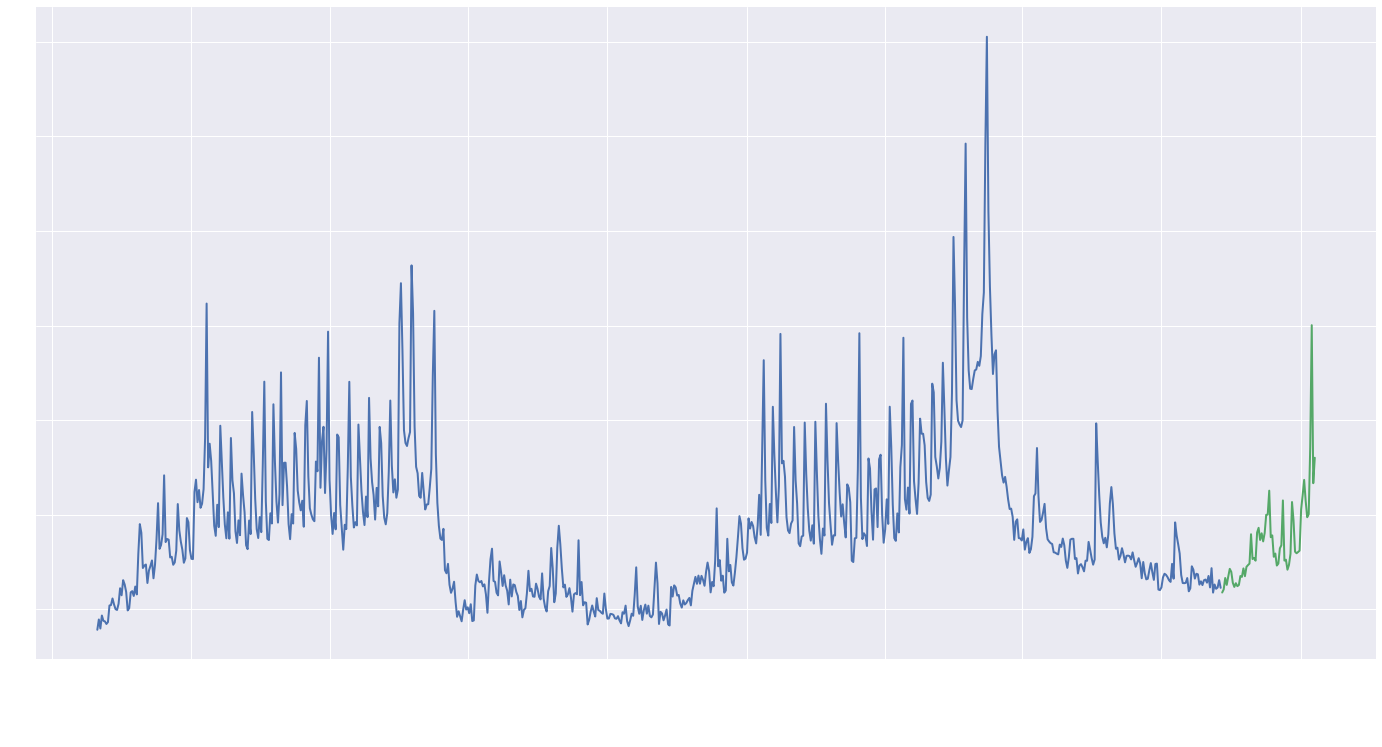

[+] History: 741, Future: 62


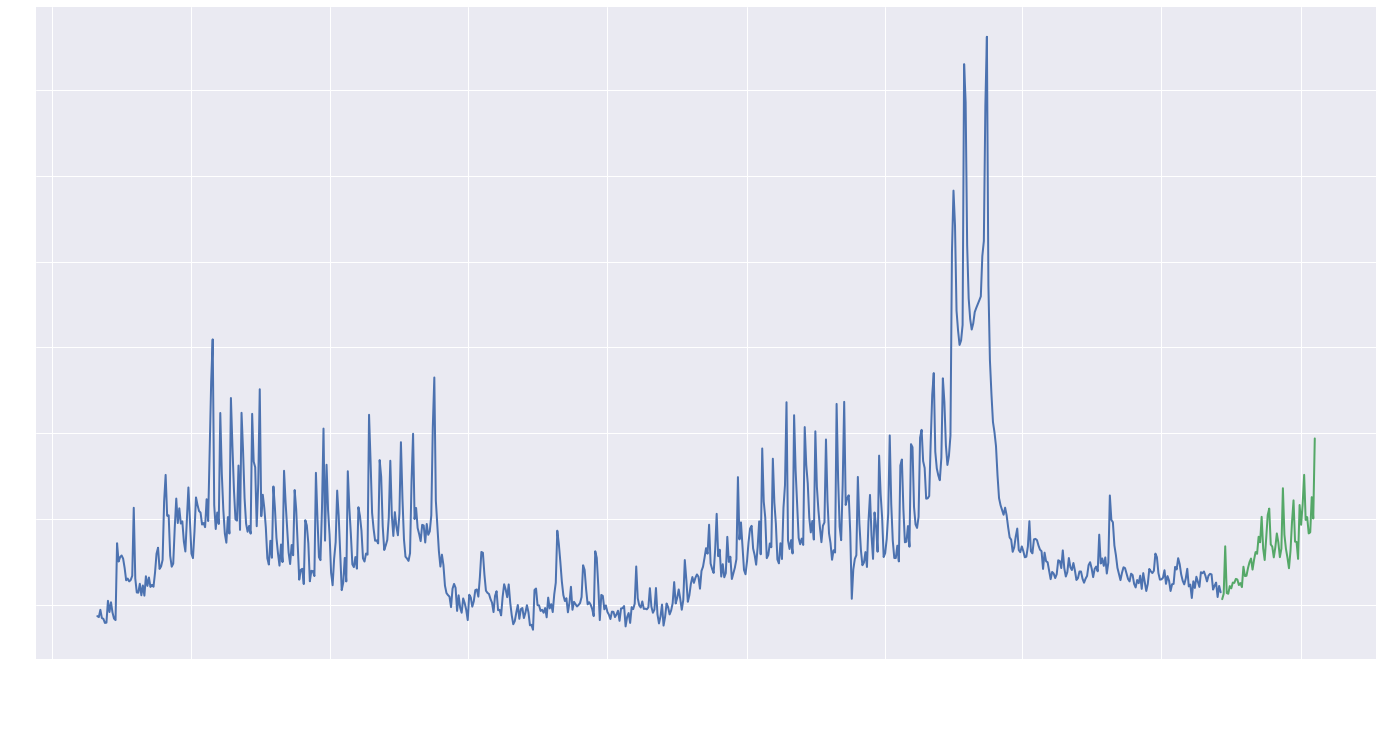

[+] History: 741, Future: 62


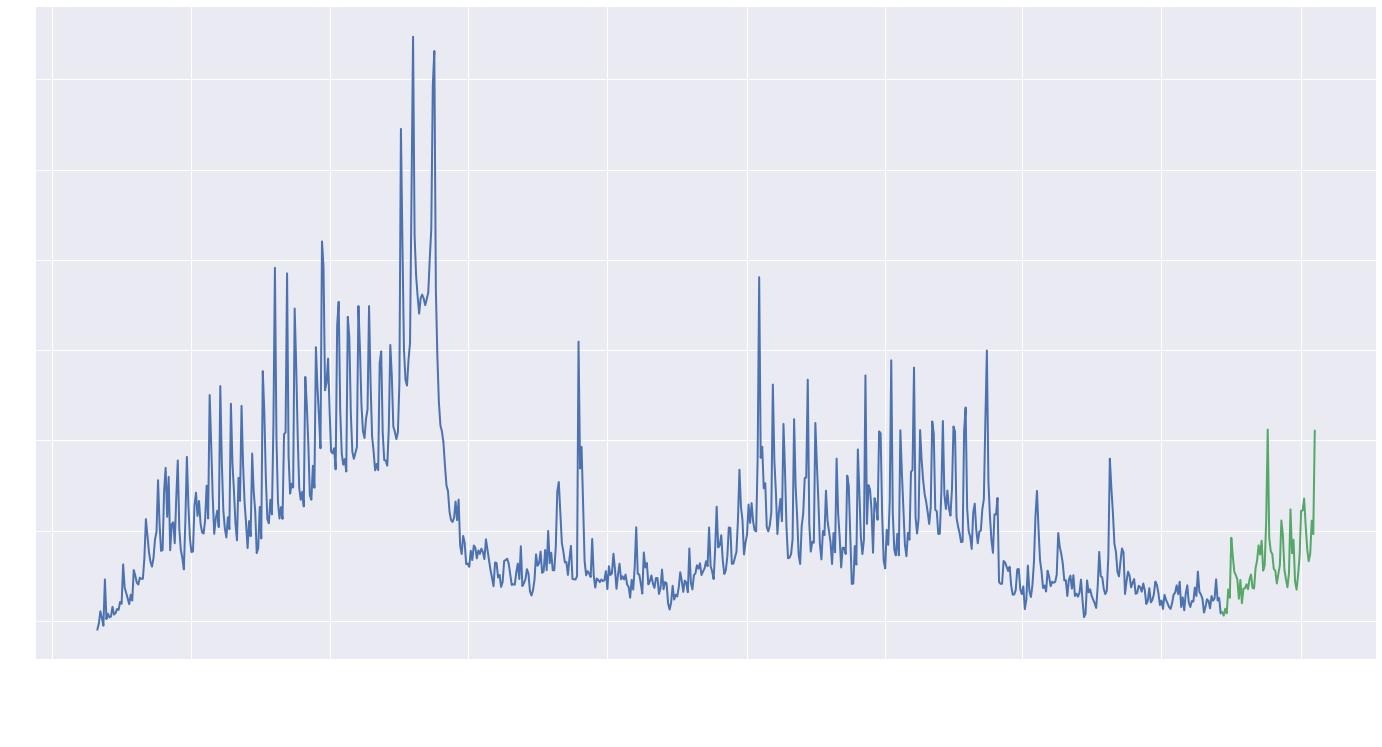

[+] History: 741, Future: 62


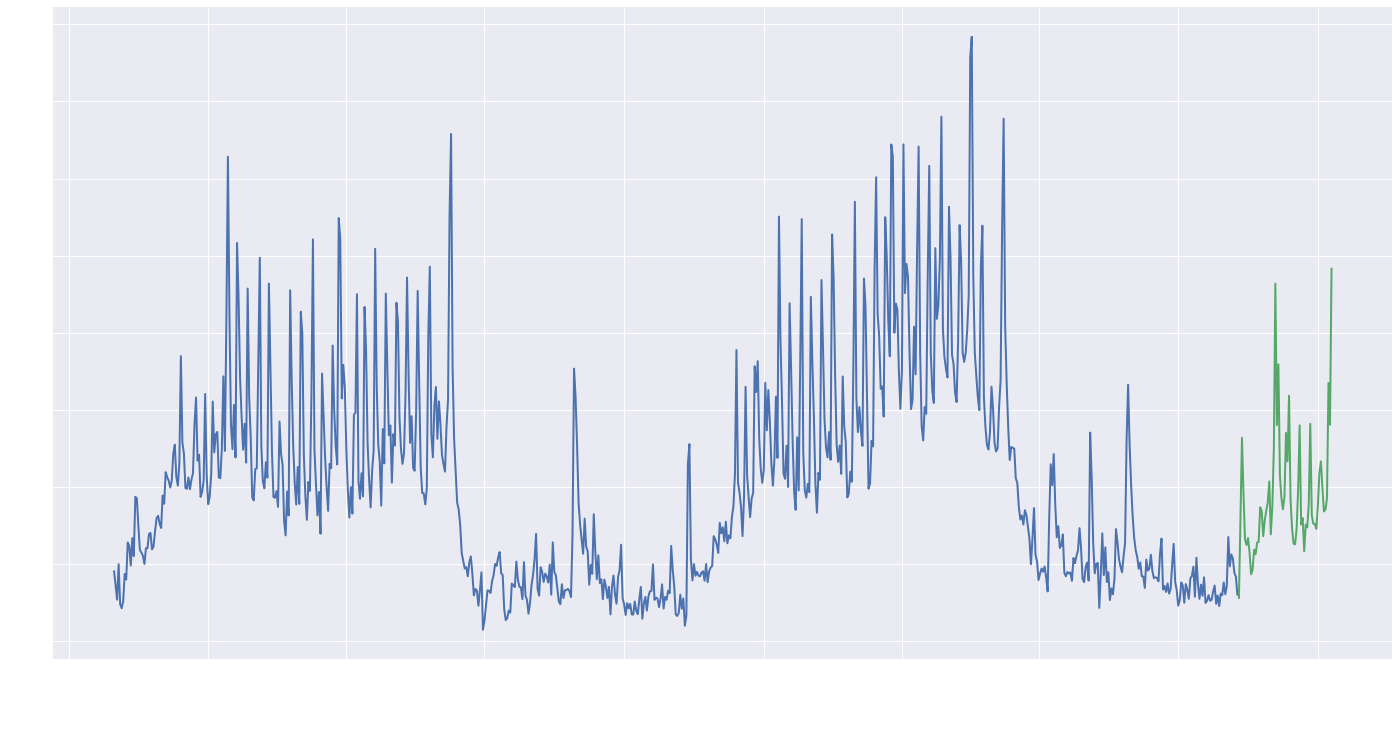

[+] History: 741, Future: 62


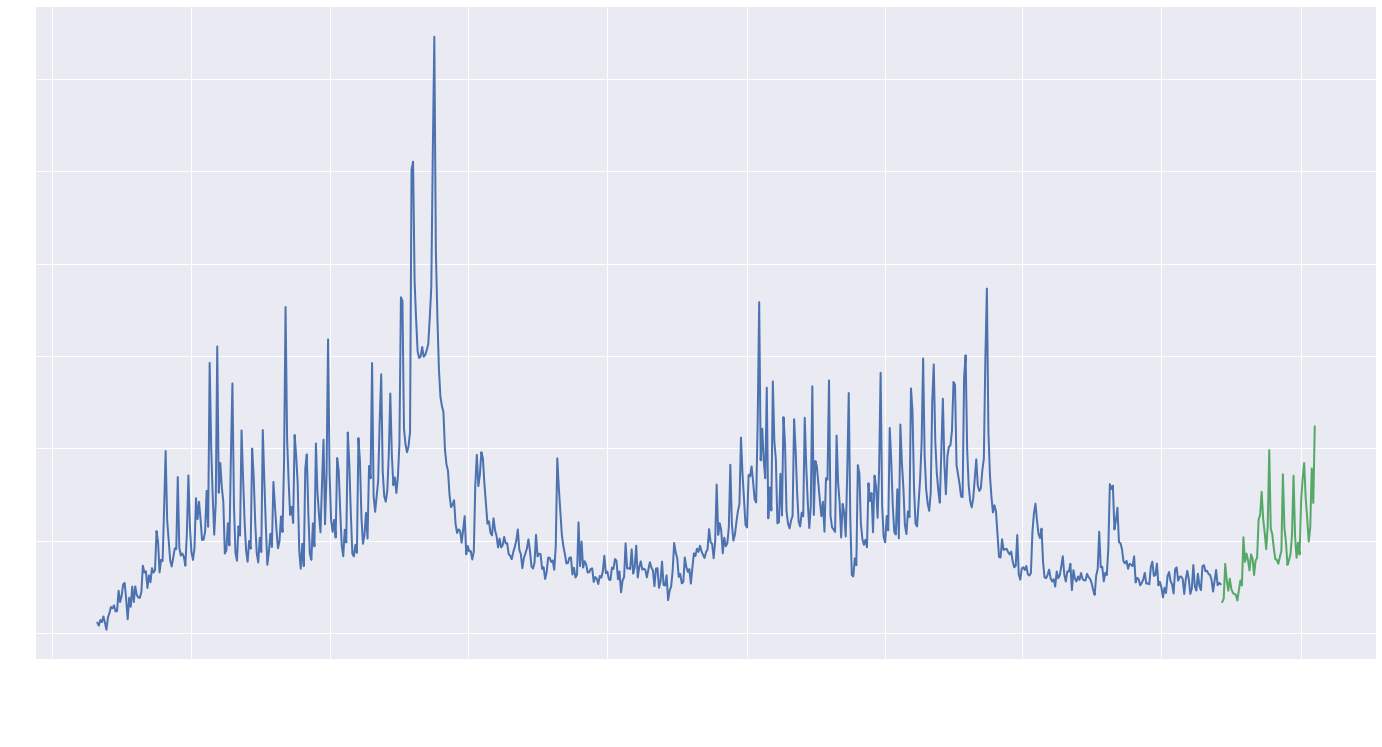

[+] History: 741, Future: 62


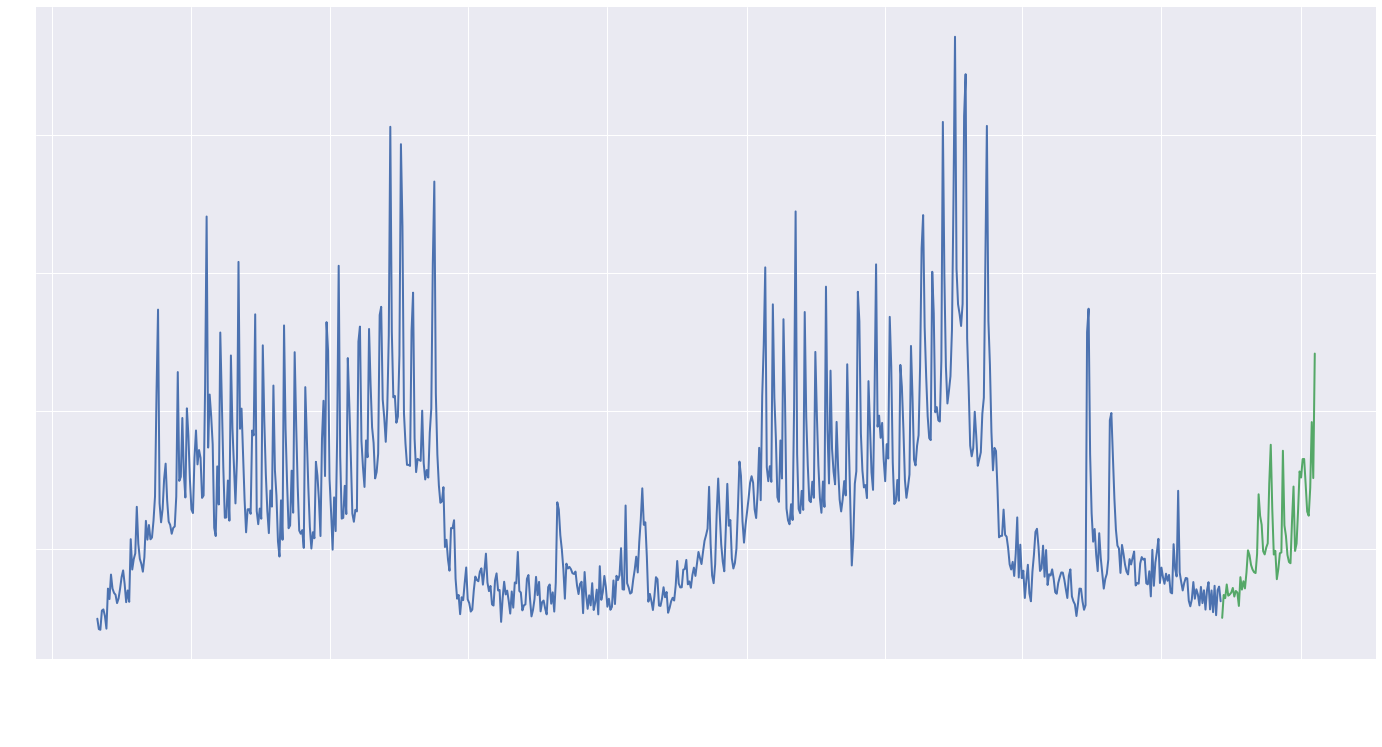

[+] History: 741, Future: 62


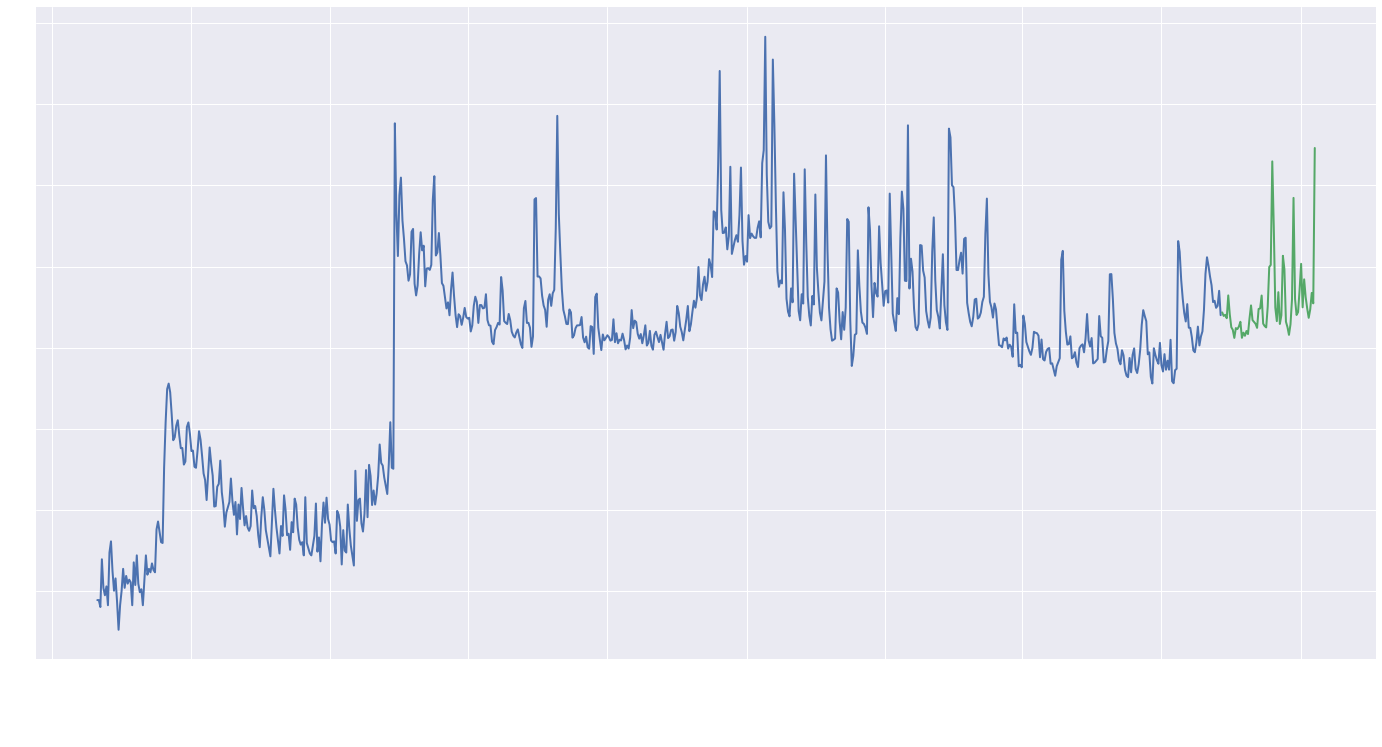

[+] History: 741, Future: 62


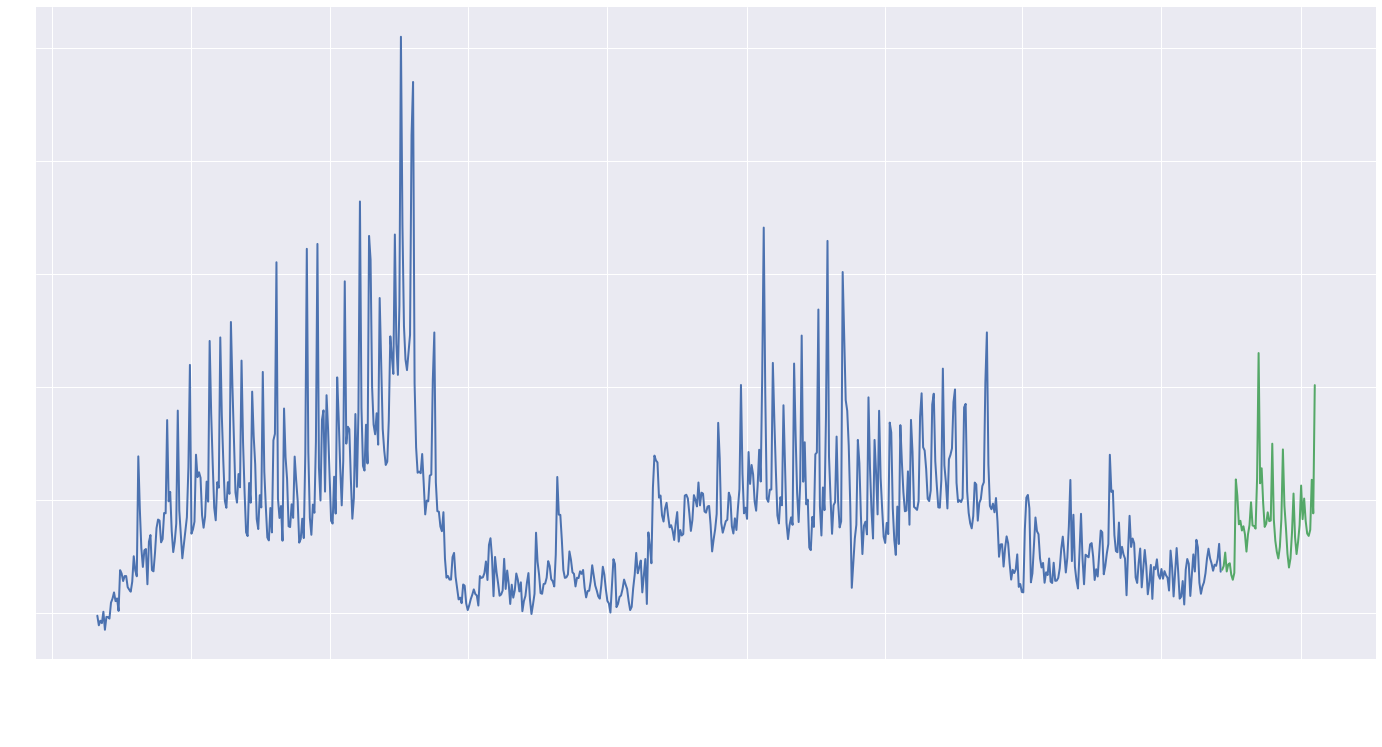

[+] History: 741, Future: 62


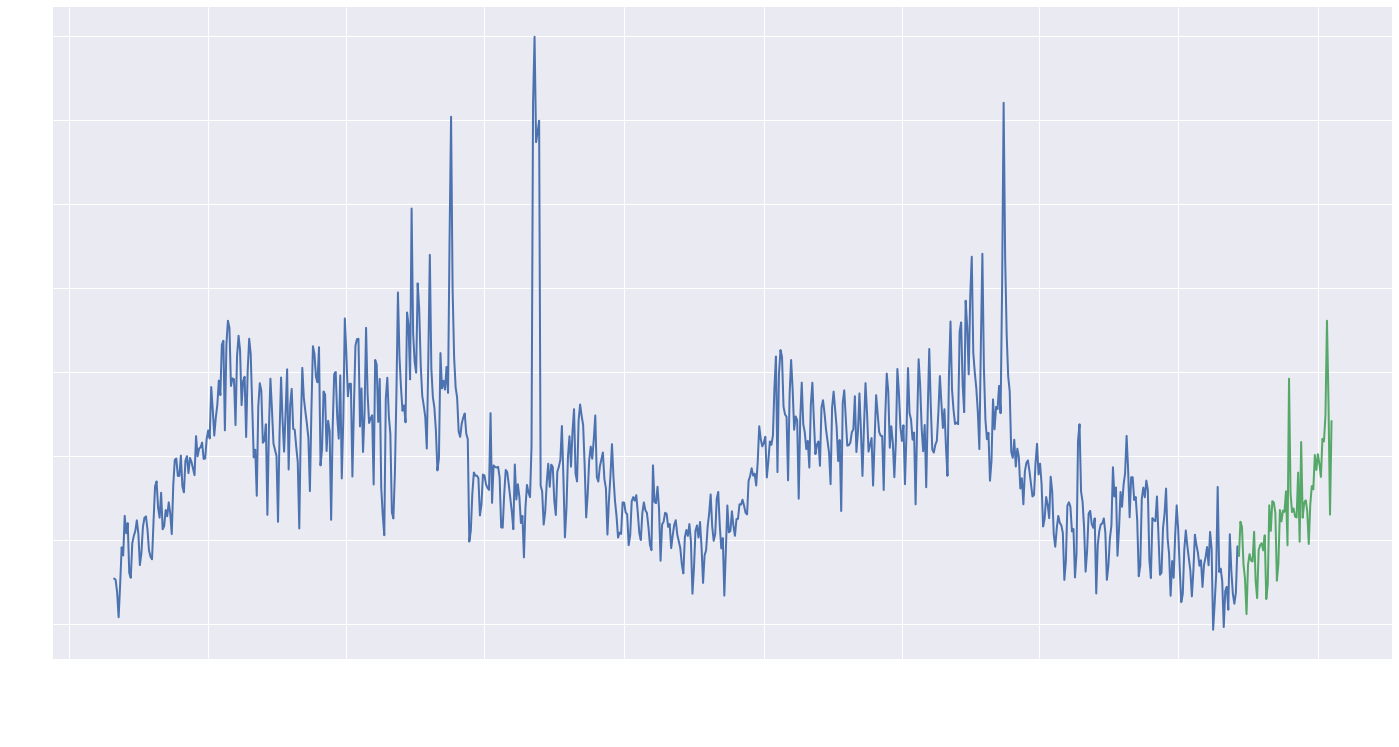

[+] History: 741, Future: 62


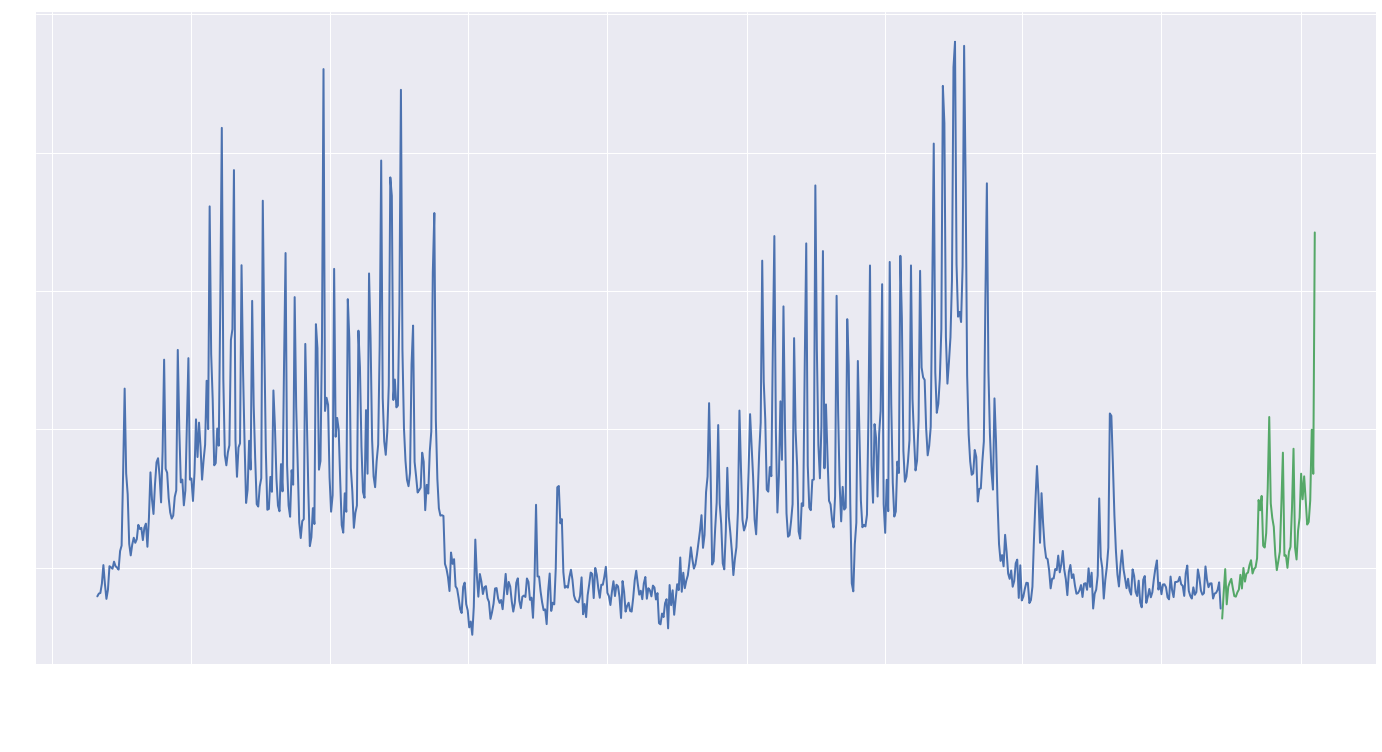

Extracting features
[+] 26 Seasonal features
	[+] ['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4', 'yearly_delim_5', 'yearly_delim_6', 'yearly_delim_7', 'yearly_delim_8', 'yearly_delim_9', 'yearly_delim_10', 'yearly_delim_11', 'yearly_delim_12', 'yearly_delim_13', 'yearly_delim_14', 'yearly_delim_15', 'yearly_delim_16', 'yearly_delim_17', 'yearly_delim_18', 'yearly_delim_19', 'yearly_delim_20', 'weekly_delim_1', 'weekly_delim_2', 'weekly_delim_3', 'weekly_delim_4', 'weekly_delim_5', 'weekly_delim_6']
[+] 25 changepoints
	 [ 0.03243243  0.06351351  0.09594595  0.12837838  0.15945946  0.19189189
  0.22432432  0.25540541  0.28783784  0.32027027  0.35135135  0.38378378
  0.41621622  0.44864865  0.47972973  0.51216216  0.54459459  0.57567568
  0.60810811  0.64054054  0.67162162  0.70405405  0.73648649  0.76756757
  0.8       ]
[+] 26 Seasonal features
	[+] ['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4', 'yearly_delim_5', 'yearly_delim_6', 'ye

In [3]:
# Split history (train) and future (test)
sdate = pd.datetime(2017, 7, 10)
ts_data = []
for df in ts_dfs: 
    history, future, y_scale = split_train_test(df, sdate)
    ts_data.append({
        "history": history, "future": future, "y_scale": y_scale
    })
    
print("Extracting features")
ts = ts_data[0] # same feature matrix for all test series  
train_data = extract_features(ts["history"])
test_data = extract_features(ts["future"], changepoints_t=train_data["t_change"])
assert(all(train_data["X"].columns ==  test_data["X"].columns))
assert(all(train_data["t_change"] == test_data["t_change"]))

## Model: FB prophet regression model
We build a regression model similar to [Facebook Prophet](https://peerj.com/preprints/3190/); it combines trend, seasonality and holiday components with non-linear smoothers applied to regressors $t \in \mathbb{Z}^{T}$. 

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}  $$

- **Trend** <br/> $$g(t) = (k + \mathbf{a}(t)^{T} \boldsymbol{\delta})t + (m + \mathbf{a}(t)^{T} \boldsymbol{\gamma})$$
    - $k$ is the growth rate (slope)
    - $m$ is the offset (intercept)
    - $S$ changepoints are explicitly defined to allow trend changes at times $s_{j \in {1,2,...,S}}$
        - $\mathbf{a}(t) \in \{0,1\}^{S}$ are changepoint indicators
        - $\delta_{j} \sim Laplace(0,\tau)$ is the change of rate at time $s_{j}$
        - $\gamma_{j}$ is set to $-s_{j}\delta_{j}$ to make the function continuous</br>


- **Seasonality** <br/>
We construct Fourier series to approximate periodic seaonality.
$$s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{P}) + b_{n}sin(\frac{2\pi nt}{P} )) = X(t)  \boldsymbol{\beta}$$
    - $\boldsymbol{\beta} = [a_{1}, b_{1} , ... , a_{N}, b_{N}]^{T}$ and $\boldsymbol{\beta} \sim Normal(0,\sigma^{2})$
    - yearly -> (P = 365.25, N = 10)
    - weekly -> (P = 7, N = 3)
    

- **Holiday/Events** <br/>
Assuming holidays are independnet, we assign each holiday with a parameter $\kappa_{i}$
$$h(t) = Z(t) \boldsymbol{\kappa}$$
    - $Z(t) = [\boldsymbol{1}(t\in D_{1}) , ... , \boldsymbol{1}(t\in D_{L})]$
    - $\boldsymbol{\kappa} \sim Normal(0, \nu^2)$

Before modeling, we transform the raw data and extract features into proper format. The input data includes

- X
    - **t: ** time index
    - **X: ** seasonality vector after fourier transformation
    - **A: ** changepoint vector given time and number of change points
    - **sigmas: ** fixed scale on seasonality priors
- y
    - **y_scaled: ** `maxdiff(log(views))`

In [4]:
N_TS = len(ts_data)
S = len(train_data["t_change"])
K = train_data["X"].shape[1]

t = tf.placeholder(tf.float32, shape=None, name="t")              # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")         # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")         # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")    # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")

k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial intercept

sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))    # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta)
beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))      # seasonal
trend_loc = (k + ed.dot(A, delta)) * t + \
            (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

### 1.Inference: HMC
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In this analysis, we use Monte Carlo with `ed.HMC` to infer all the latent variables. All training data are passed in for inference and we tune step_size $= 0.0005$, n_steps $= 2$.

In [5]:
ITR = 5000
kinit, minit = init_km(ts_data[0]["history"])
print("[+] Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))

[+] Initial slope / intercept: 0.033978, 0.519842


In [7]:
posts_dict = {
    k: qk, m: qm, sigma_obs: qsigma_obs,
    beta: qbeta, delta: qdelta}

data_dict = {
    y: ts_data[0]["history"]["y_scaled"].as_matrix(),
    t: train_data["t"],
    X: train_data["X"],
    sigmas: train_data["sigmas"],
    A: train_data["A"],
    t_change: train_data["t_change"],
    tau: 0.05,
}

inference = ed.HMC(posts_dict, data=data_dict)
STEP_SIZE = 5e-4
N_STEPS = 2
inference.run(step_size=STEP_SIZE, n_steps=N_STEPS)

5000/5000 [100%] ██████████████████████████████ Elapsed: 21s | Acceptance Rate: 0.947


### 1.Prediction

0.0300145 0.605465 [ -1.93206687e-02  -2.83005703e-02  -1.09854206e-01   4.73710634e-02
  -4.25103158e-02  -2.67562121e-02   2.21625362e-02   1.98265351e-03
   1.21680796e-01   1.99236590e-02   3.55673730e-02   2.83004940e-02
  -3.18188313e-03  -1.19131170e-02  -7.66217363e-06  -4.67566252e-02
  -2.34914403e-02   3.09261568e-02   1.60106048e-01   1.29921902e-02
  -5.43556921e-03  -9.83557478e-02   1.35422722e-02  -7.48062099e-04
  -6.72171935e-02]
MAPE = 4.021235
SMAPE = 3.948216
MSE = 0.000871


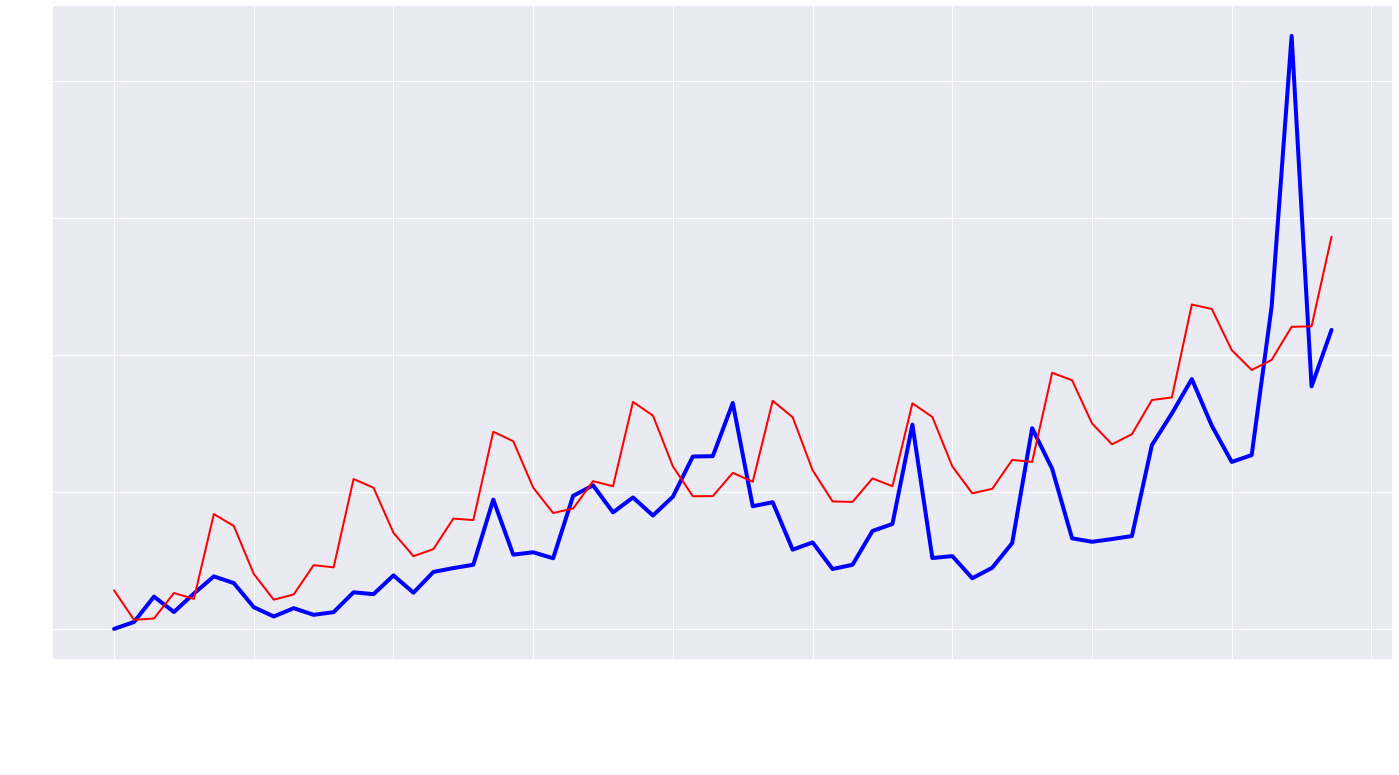

In [8]:
from prediction import *
nburn = int(ITR / 2)
stride = 10
sess = ed.get_session()
post_params = {
    "k": qk.params.eval()[nburn:ITR:stride],
    "m": qm.params.eval()[nburn:ITR:stride],
    "beta": qbeta.params.eval()[nburn:ITR:stride],
    "delta": qdelta.params.eval()[nburn:ITR:stride]
}
ts = ts_data[0]
pred_df =  make_future_dataframe(ts["history"], ts["future"].shape[0])
pred_df = predict_fixed(pred_df, post_params, test_data)
y_true = ts["future"]["y_scaled"].as_matrix()
_  = evaluate(y_true, pred_df["y"])

plt.plot(ts["future"]["ds"], ts["future"]["y_scaled"], lw=4, color='b')
plt.plot(ts["future"]["ds"], pred_df["y"], color='r')
plt.xticks(rotation=90)
plt.show()
            
# test_data_dict =  {
#     t: test_data["t"],
#     X: test_data["X"],
#     sigmas: test_data["sigmas"],
#     A: test_data["A"],
#     t_change: test_data["t_change"],
#     tau: 0.05,
# }
# CI = [20, 80]
# y_true = ts_data[0]["future"]["y_scaled"]
# y_pred = predict(y, posts_dict, test_data_dict, SAMPLE=500)
# y_pred_mean = np.mean(y_pred, axis=0)[0]
# y_pred_lower = np.percentile(y_pred, CI, axis=0)[0][0]
# y_pred_upper = np.percentile(y_pred, CI, axis=0)[1][0]
# plt.plot(ts_data[0]["future"]["t"], y_true,lw=4, color='b')
# plt.plot(ts_data[0]["future"]["t"], y_pred_mean,lw=4, color='r')
# plt.fill_between(ts_data[0]["future"]["t"], y_pred_lower,y_pred_upper,color='b',alpha=.05)
# plt.show()

# plt.plot(ts_data[0]["future"]["t"],  y_pred_mean - y_true, color='b', label="residual")
# plt.plot(ts_data[0]["future"]["t"],  np.zeros(y_true.shape), label="residual")
# plt.show()

In [9]:
print(S)

25


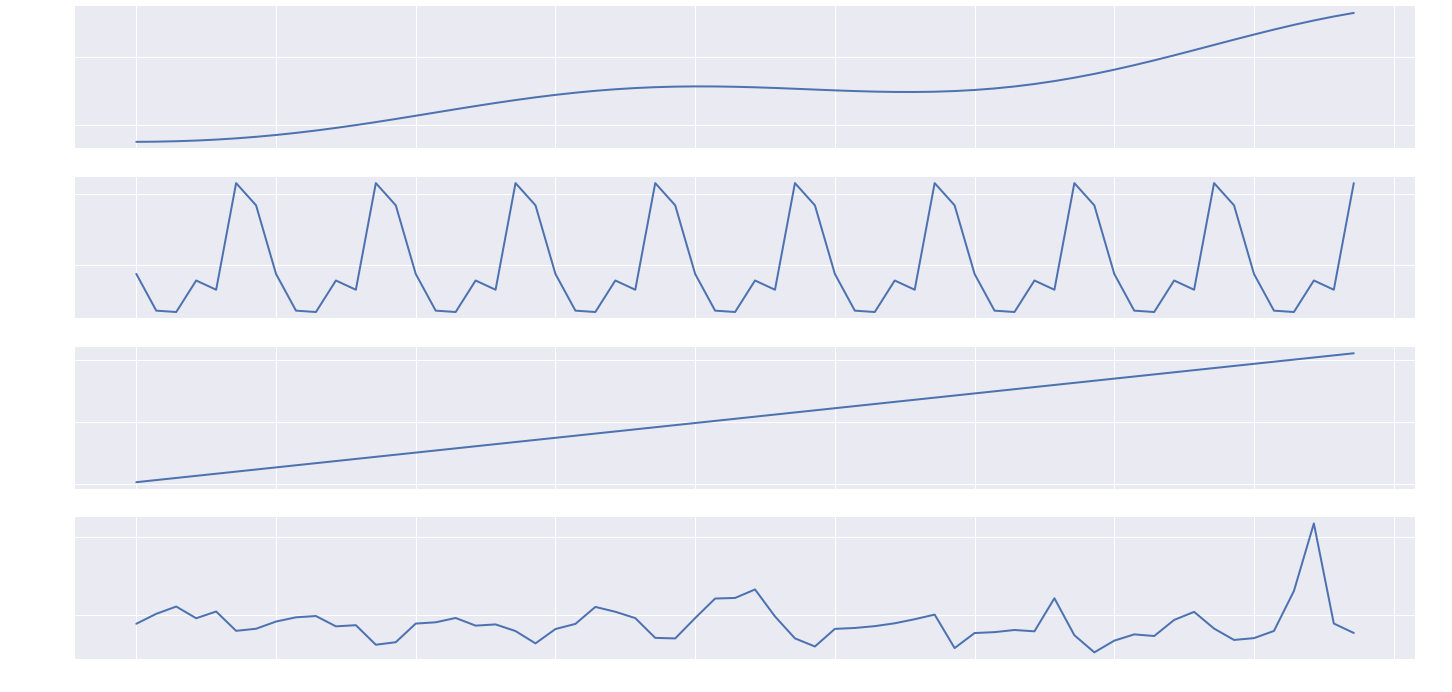

In [8]:
plt.subplot(411) 
plt.plot(ts["future"]["ds"], pred_df["yearly"])
plt.subplot(412)
plt.plot(ts["future"]["ds"], pred_df["weekly"])
plt.subplot(413)
plt.plot(ts["future"]["ds"], pred_df["trend"])
plt.subplot(414)
plt.plot(ts["future"]["ds"], y_true - pred_df["y"])
plt.show()

/home/amy/Documents/Courses/Fall2017/Model/workspace/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


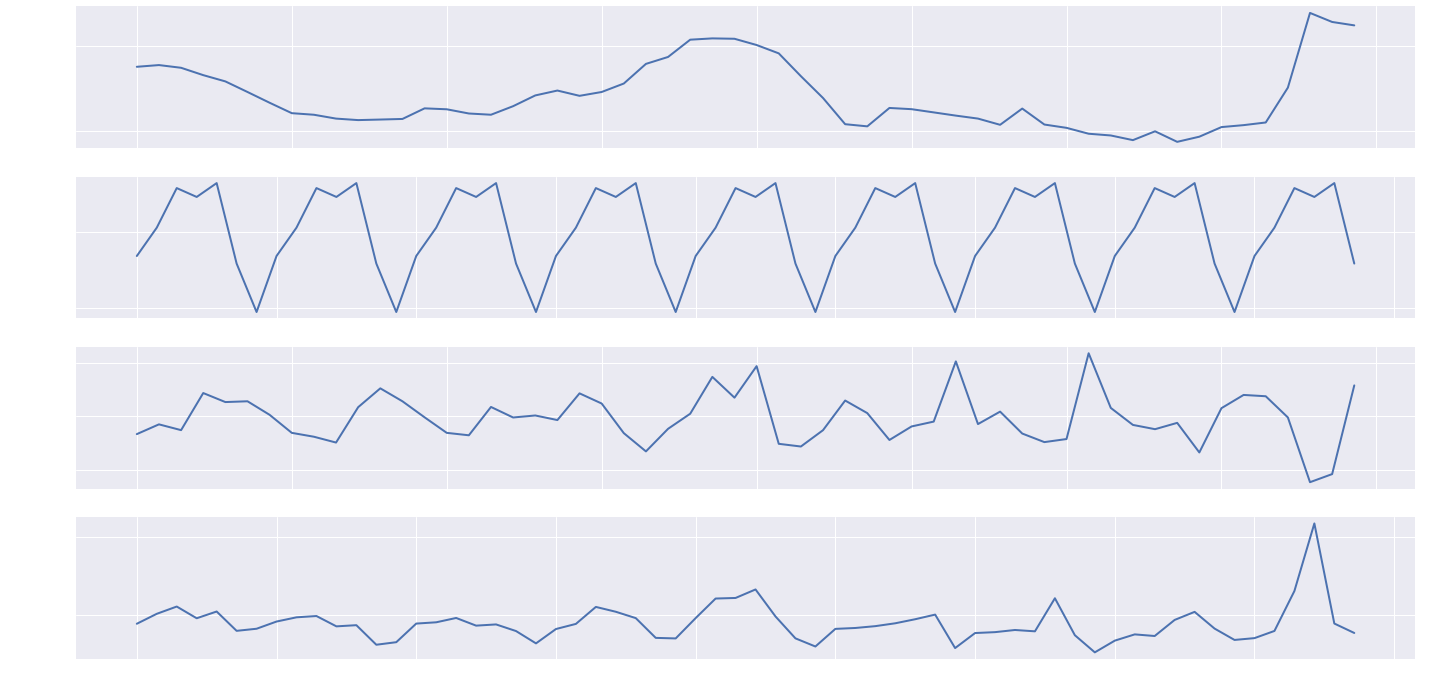

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
pred_df.index = pred_df["ds"]
decomposition = seasonal_decompose(y_true - pred_df["y"])
plt.subplot(411) 
plt.plot(decomposition.trend)
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.subplot(413)
plt.plot(decomposition.resid)
plt.subplot(414)
plt.plot(ts["future"]["ds"], y_true - pred_df["y"])
plt.show()

In [10]:
pred_df.head()

ds         t     trend  seasonal  seasonal_lower  \
ds                                                                    
2017-07-11 2017-07-11  1.001351  0.625805 -0.064951       -0.072163   
2017-07-12 2017-07-12  1.002703  0.625812 -0.075177       -0.082648   
2017-07-13 2017-07-13  1.004054  0.625818 -0.075250       -0.083190   
2017-07-14 2017-07-14  1.005405  0.625825 -0.065851       -0.073213   
2017-07-15 2017-07-15  1.006757  0.625832 -0.067759       -0.074098   

            seasonal_upper    weekly  weekly_lower  weekly_upper    yearly  \
ds                                                                           
2017-07-11       -0.058237 -0.002512     -0.005965      0.000715 -0.062439   
2017-07-12       -0.068928 -0.012875     -0.016597     -0.009323 -0.062302   
2017-07-13       -0.068256 -0.013259     -0.016941     -0.009836 -0.061991   
2017-07-14       -0.059011 -0.004362     -0.008037     -0.000918 -0.061489   
2017-07-15       -0.060917 -0.006975     -0.010818     -0.003361 -0.060784   

            yearly_lower  yearly_upper         y  
ds                                                
2017-07-11     -0.068518     -0.056806  0.560853  
2017-07-12     -0.068595     -0.056506  0.550634  
2017-07-13     -0.068182     -0.055971  0.550568  
2017-07-14     -0.067485     -0.055481  0.559974  
2017-07-15     -0.066840     -0.054608  0.558073

0.0300145 0.605465 [ -1.93206687e-02  -2.83005703e-02  -1.09854206e-01   4.73710634e-02
  -4.25103158e-02  -2.67562121e-02   2.21625362e-02   1.98265351e-03
   1.21680796e-01   1.99236590e-02   3.55673730e-02   2.83004940e-02
  -3.18188313e-03  -1.19131170e-02  -7.66217363e-06  -4.67566252e-02
  -2.34914403e-02   3.09261568e-02   1.60106048e-01   1.29921902e-02
  -5.43556921e-03  -9.83557478e-02   1.35422722e-02  -7.48062099e-04
  -6.72171935e-02]


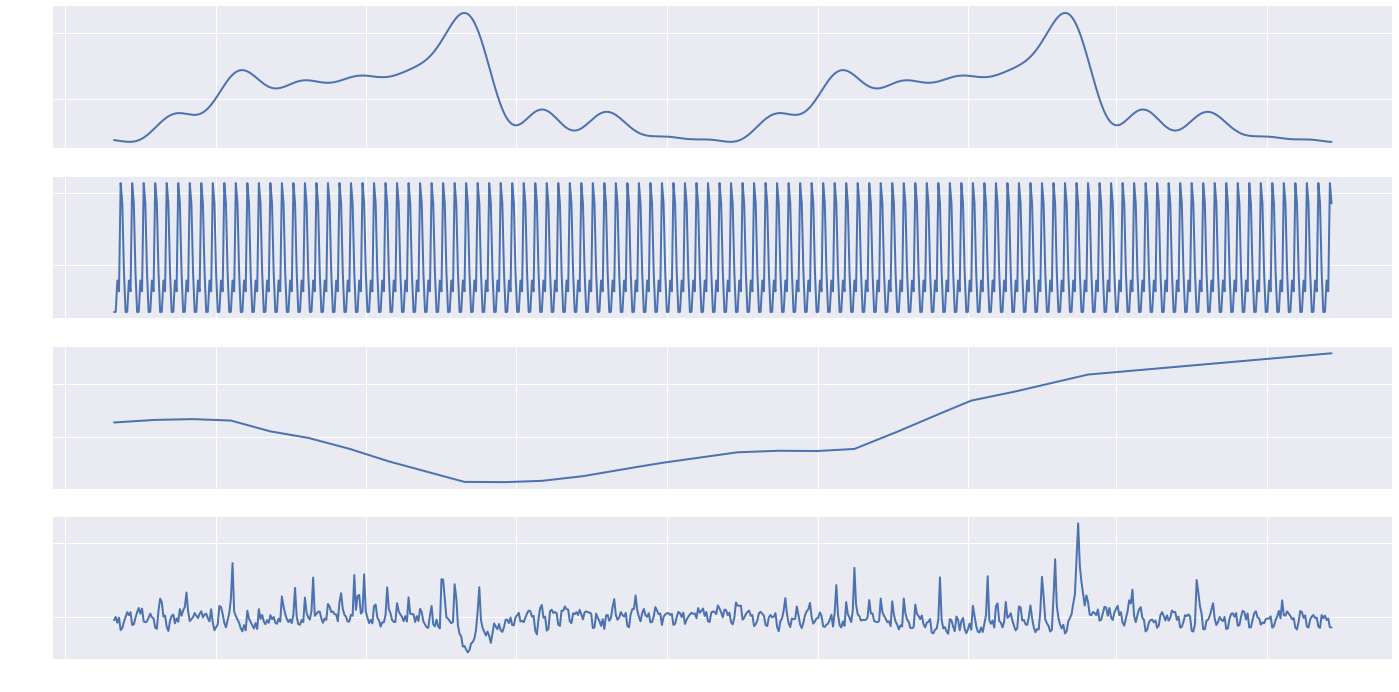

In [10]:


history_pred_df = pd.DataFrame({"ds": ts["history"]["ds"].copy(),
                                "t": ts["history"]["t"].copy()})
history_pred_df.reset_index(inplace=True, drop=True)
history_pred_df = predict_fixed(history_pred_df, post_params, train_data)
plt.subplot(411) 
plt.plot(ts["history"]["ds"], history_pred_df["yearly"])
plt.subplot(412)
plt.plot(ts["history"]["ds"], history_pred_df["weekly"])
plt.subplot(413)
plt.plot(ts["history"]["ds"], history_pred_df["trend"])
plt.subplot(414)
plt.plot(ts["history"]["ds"], ts["history"]["y_scaled"].as_matrix() - history_pred_df["y"])
plt.show()

In [11]:
pred_df.index = pred_df["ds"]
decomposition = seasonal_decompose(ts["history"]["y_scaled"].as_matrix() - history_pred_df["y"])
plt.subplot(411) 
plt.plot(decomposition.trend)
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.subplot(413)
plt.plot(decomposition.resid)
plt.subplot(414)
plt.plot(ts["future"]["ds"], y_true - pred_df["y"])
plt.show()

NameError: name 'seasonal_decompose' is not defined

In [12]:
# Another timeseries


### 1.Criticism
- Visualization of the residuals
- Pointwise Evaluation
    - MAPE
    - SMAPE
    - MSE
- PPC

MAPE = 3.206620
SMAPE = 3.180777
MSE = 0.000666


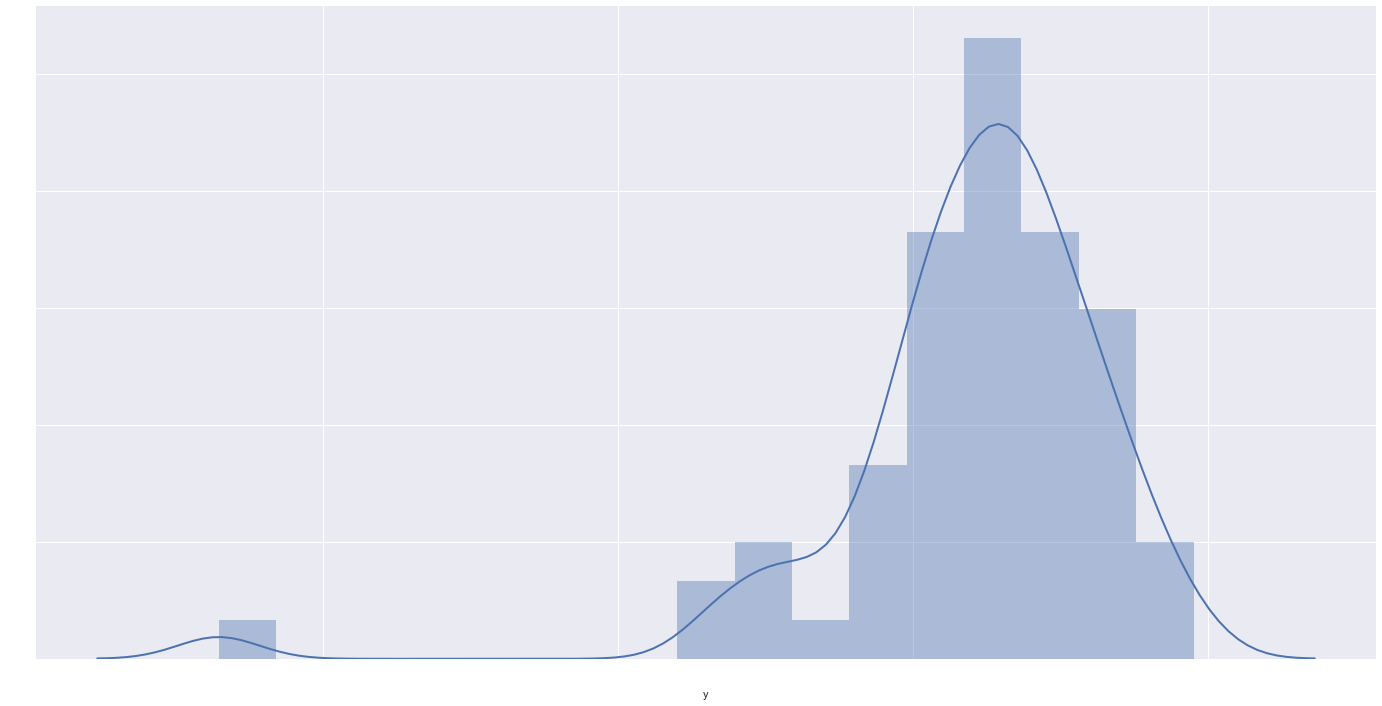

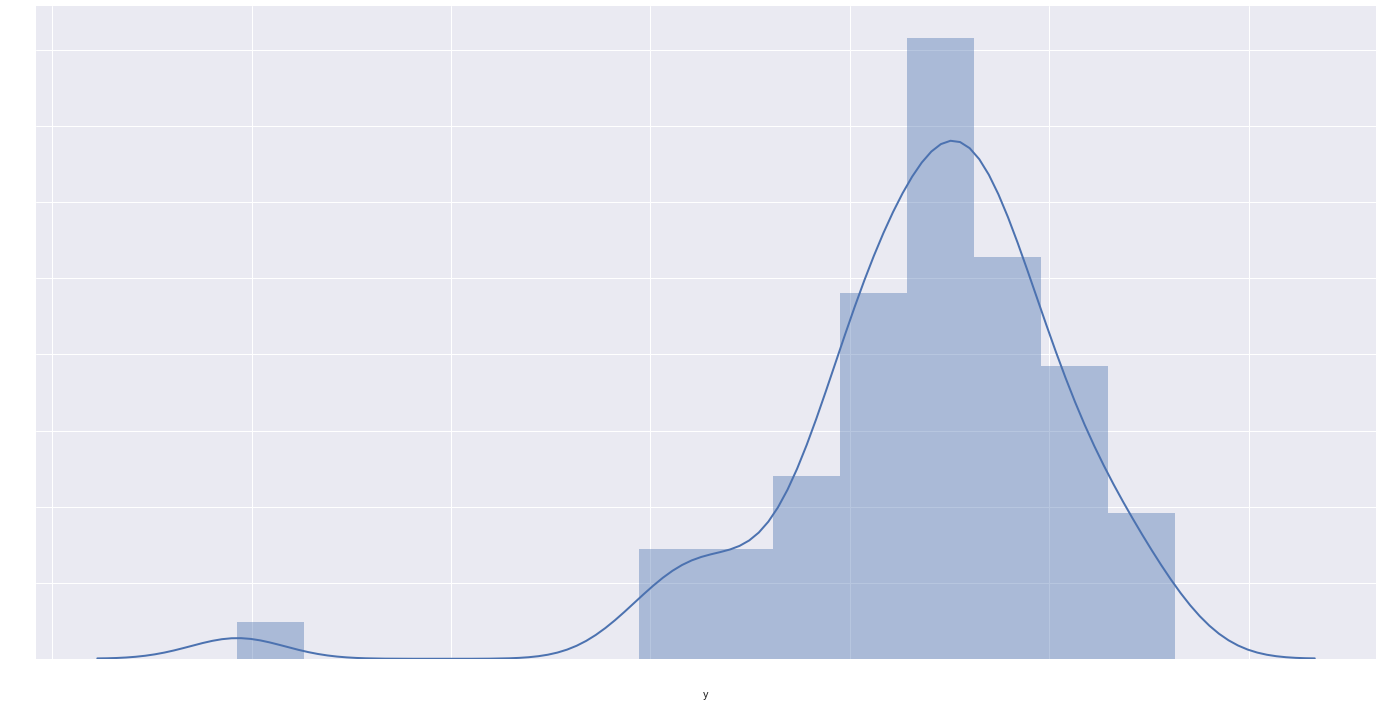

In [13]:
evaluate(y_true, pred_df["y"])
sns.distplot(pred_df["y"] - y_true)
plt.show()
sns.distplot((pred_df["y"] - y_true)/y_true)
plt.show()

Inferred posterior k: mean = 0.077008, stddev = 0.017727
Inferred posterior m: mean = 0.573739, stddev = 0.038756
0.0818582
5000


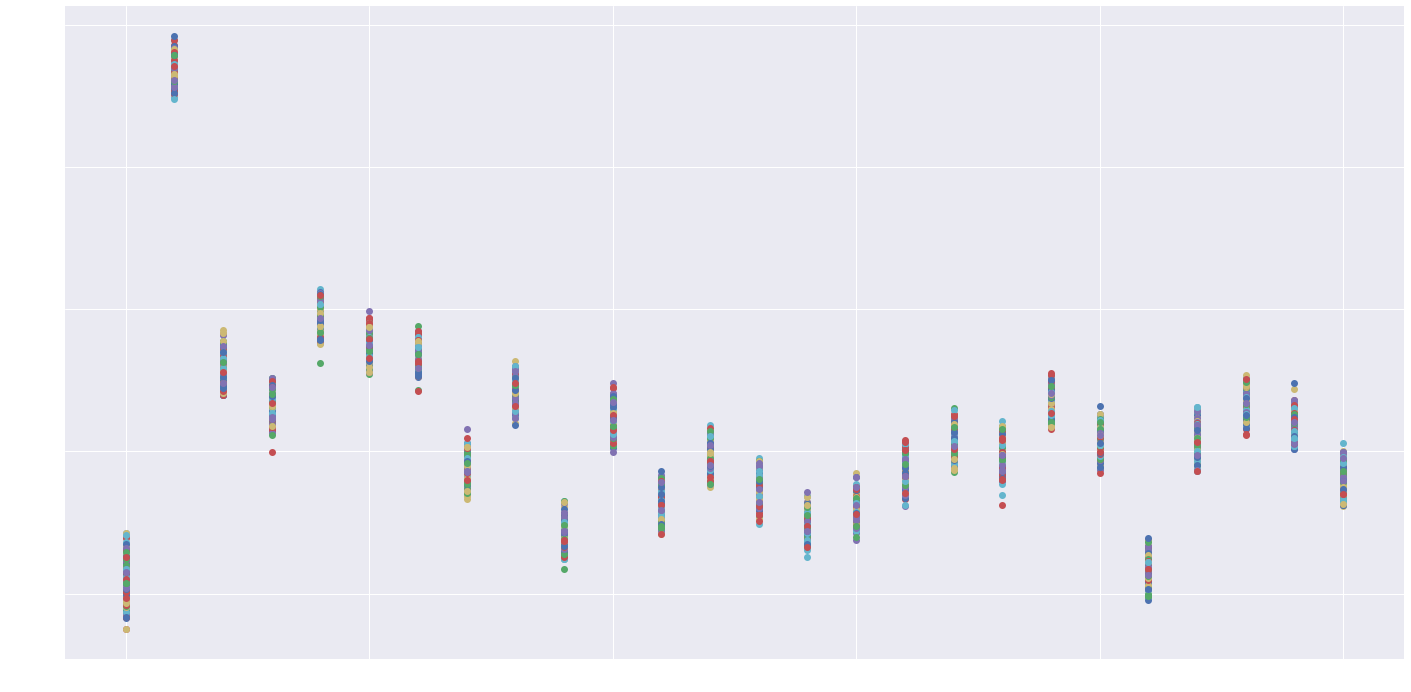

In [14]:
# Posterior check
sess = ed.get_session()
kmean, kstddev = sess.run([qk.mean(), qk.stddev()])
print("Inferred posterior k: mean = %f, stddev = %f" % (kmean, kstddev))
mmean, mstddev = sess.run([qm.mean(), qm.stddev()])
print("Inferred posterior m: mean = %f, stddev = %f" % (mmean, mstddev))
print(np.mean(post_params["k"]))

# plt.plot(qk.params.eval())
# plt.show()

# plt.plot(post_params["k"])
# plt.show()
nburn = int(ITR/2)
stride = 10
print(ITR)
for beta in post_params["beta"]:
    plt.plot(beta, 'o')
plt.show()

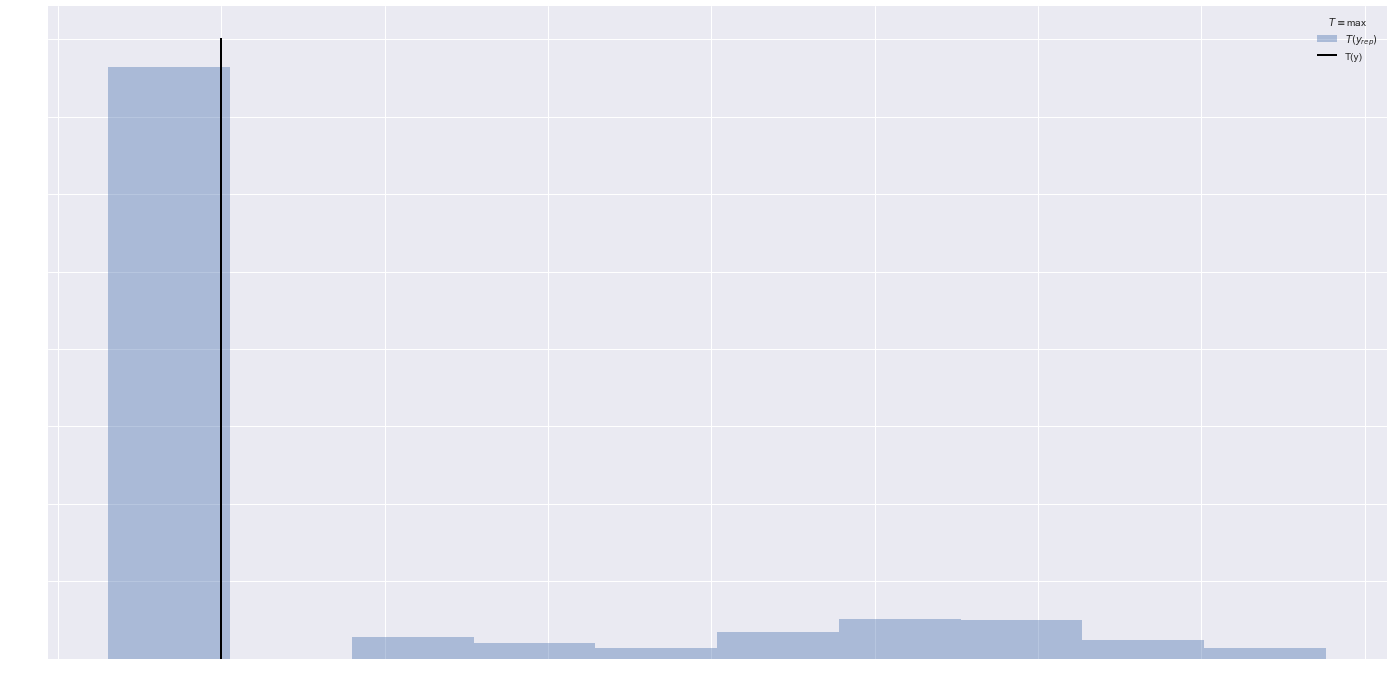

In [15]:
y_post = ed.copy(y, posts_dict)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_max(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    

# y: ts_data[0]["history"]["y_scaled"].as_matrix(),
#     t: train_data["t"],
#     X: train_data["X"],
#     sigmas: train_data["sigmas"],
#     A: train_data["A"],
#     t_change: train_data["t_change"]

ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$max', bins=10)
plt.show()

## Round 1.5: 
___

### Improvements
- motify init k and m
- remove holiday features why us public holiday not works, require in-domain knowledge
- tau from fixed value to latent variable

## Round 2: 
___
### 2.Model
We modify the model by creating global latent variable inferring local seasonality  
- Local latend variable
    - 
- Global latent variable
    - `gbeta`
    
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In [16]:
# def visualize_results(ts_data, predictions, metrics):
#     for i, df in enumerate(ts_dfs):
#         plt.plot(ts_data[i]["future"]["ds"], ts_data[i]["future"]["y_scaled"])
#         plt.plot(predictions[i]["ds"], predictions[i]["y_scaled_pred"], '#2ca02c')
#         plt.show()  
#     m_pd = pd.DataFrame.from_dict(metrics)
#     m_pd.loc['mean'] = m_pd.mean()
#     print(m_pd)
#     print()

# def visualize_cross_validation(ts_dfs, predictions, metrics):
#     for i, df in enumerate(ts_dfs):
#         df = df[df["ds"] > pd.datetime(2016,6,1)]
#         plt.plot(df["ds"], df["y"])
#         for pred in predictions:
#             plt.plot(pred[i]["ds"], pred[i]["y_pred"], '#2ca02c')
#         plt.show()
    
#     metrics_df = pd.DataFrame(columns=['start', 'end', 'MAPE_avg', 'SMAPE_avg'])
#     for i, m_cutoff in enumerate(metrics):
#         dmin, dmax = predictions[i][0]["ds"].min(), predictions[i][0]["ds"].max()
#         avg_mape_scaled = np.mean([m["MAPE"] for m in m_cutoff])
#         avg_smape_scaled = np.mean([m["SMAPE"] for m in m_cutoff])
#         metrics_df = metrics_df.append({"start": dmin,
#                                         "end": dmax,
#                                         "MAPE_avg": avg_mape_scaled, 
#                                         "SMAPE_avg": avg_smape_scaled}, ignore_index=True)
    
#     print(metrics_df)

In [17]:
#%%capture
results = []
models_test = [Model1(), Model3()]
print(train_data.keys())
print("Fitting %d Timeseries" % len(ts_data))
for model in models_test:
    p, m = pipeline(ts_data, model, train_data, test_data, 
                    ITR=5000, N_STEPS=2, STEP_SIZE=5e-4)
    results.append({"predictions": p, "metrics": m})

In [18]:
for j, r in enumerate(results):
    m_pd = pd.DataFrame.from_dict(r["metrics"])
    m_pd.loc['mean'] = m_pd.mean()
    print(m_pd)

          MAPE       MSE     SMAPE
0     5.645831  0.001458  5.475496
1     3.692716  0.000869  3.605979
2     3.286806  0.000967  3.373480
3     5.591567  0.001090  5.402979
4     3.259774  0.000559  3.318791
5     3.734318  0.001000  3.727611
6     6.930625  0.003564  7.269681
7     5.095960  0.001386  5.301383
8     4.386394  0.001572  4.343722
9     5.223353  0.001650  5.066224
mean  4.684734  0.001411  4.688535
          MAPE       MSE     SMAPE
0     5.181762  0.001273  5.037560
1     4.676122  0.001261  4.540866
2     3.051415  0.000862  3.128161
3     6.134463  0.001374  5.900053
4     3.434646  0.000666  3.520422
5     4.074867  0.001086  4.028252
6     5.892632  0.002473  6.073961
7     5.355774  0.001508  5.599459
8     4.066421  0.001439  4.077156
9     4.891003  0.001589  4.745049
mean  4.675910  0.001353  4.665094


In [12]:
# Model 1
for m, model in enumerate(models_test[:1]):
    print("Model %d" % m)
    for i, ts in enumerate(ts_data[:2]):
        print(init_km(ts["history"]))
        sns.distplot(model.post_params[i]["k"])
        print(model.post_params[i])
    plt.show()  


# for m, model in enumerate(models_test[0]):
#     print("Model %d" % m)
#     for i, ts in enumerate(ts_data[1:2]):
#         for beta in model.post_params[i]["beta"]:
#             plt.plot(beta, 'o')
#         plt.show()
   
    

NameError: name 'models_test' is not defined

In [26]:
# Fit Training 
results_train = []
for model in models_test:
    predictions = []
    metrics = []
    for i, ts in enumerate(ts_data):
        df = pd.DataFrame({"ds": ts["history"]["ds"].copy(),
                           "t": ts["history"]["t"].copy()})
        df.reset_index(inplace=True, drop=True)
        df = predict_fixed(df, model.post_params[i], train_data)
        predictions.append(df)
        
        y_true = ts["history"]["y_scaled"].as_matrix()
        metrics.append(evaluate(y_true, df["y"]))
            
    results_train.append({
        "predictions": predictions, 
        "metrics": metrics,
    })

0.0270072 0.596727 [-0.00483925 -0.00372534 -0.00995081 -0.01048691 -0.03512265 -0.02837103
 -0.00708821 -0.01704973  0.0135425   0.02807025  0.01529508  0.03301634
  0.07866182  0.00837404 -0.0219764   0.01701566  0.00874663  0.00297215
 -0.01197413  0.01200357 -0.02449854  0.02755913  0.00297034  0.0031887
 -0.00738662]
MAPE = 3.372601
SMAPE = 3.388474
MSE = 0.001008
0.0600293 0.675516 [-0.01863857 -0.02307013 -0.02701805  0.00263918  0.00097696  0.01539947
 -0.02430836 -0.00108096  0.00756647  0.01766875 -0.0038389  -0.00228343
  0.00909786  0.00331715  0.00624081  0.01461301  0.00980789  0.00325136
  0.00532388  0.0079355  -0.00891365 -0.0043071  -0.00322948 -0.01785719
 -0.04377991]
MAPE = 3.357873
SMAPE = 3.381807
MSE = 0.001198
0.0728906 0.763331 [-0.01860125 -0.00787824 -0.0619931   0.01790362  0.00356567 -0.0021094
 -0.00669879 -0.00120851 -0.00459525 -0.01343241  0.02795773 -0.03575064
  0.00352739  0.00438849  0.00179967  0.00436181 -0.01788452  0.00106254
 -0.008428   -0.00

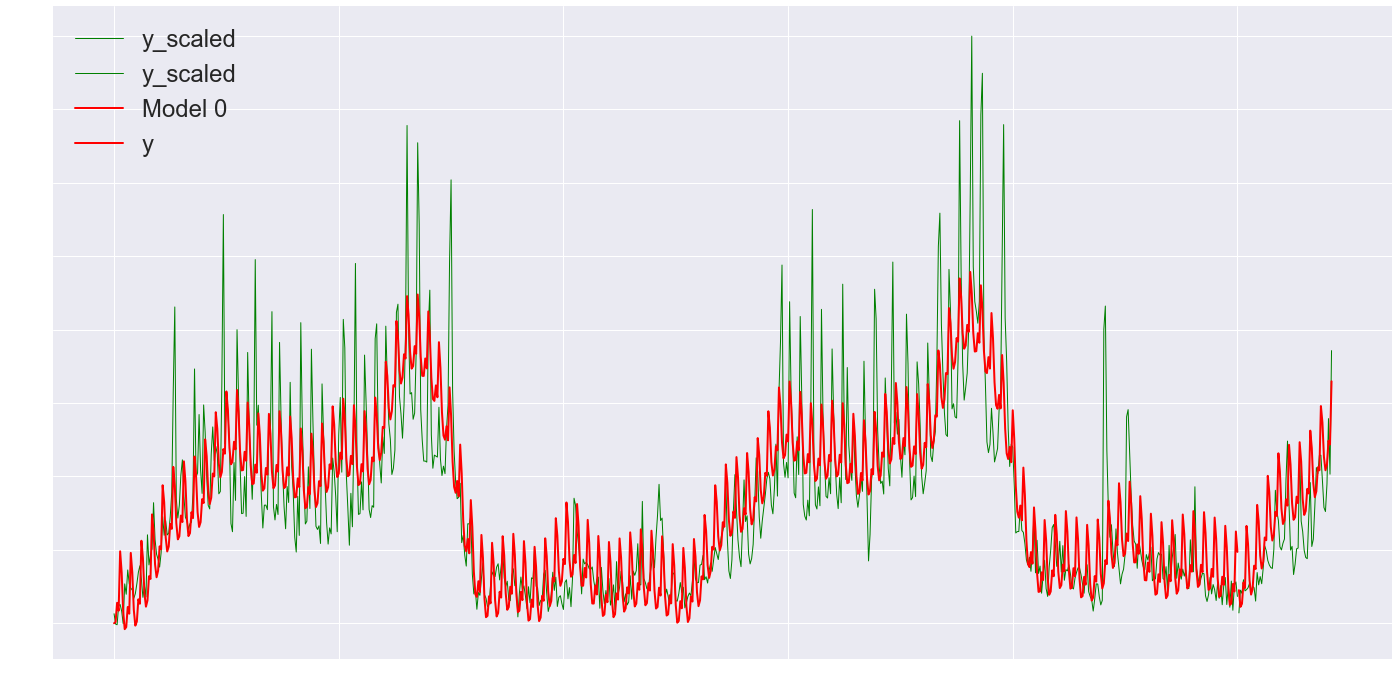

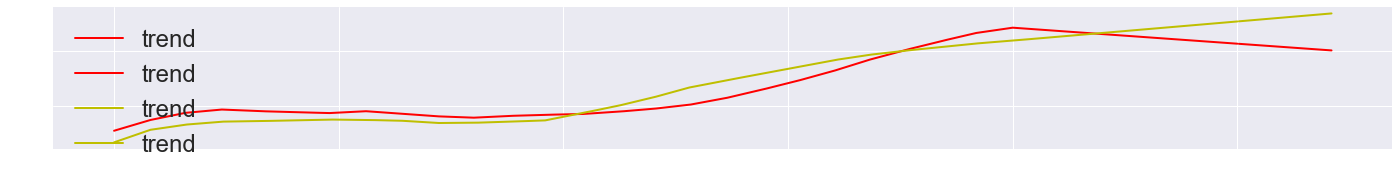

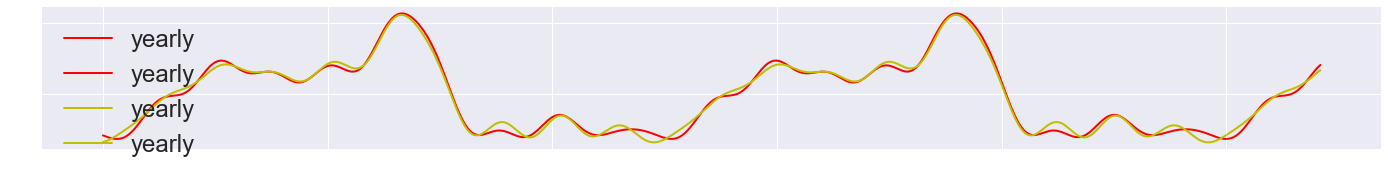

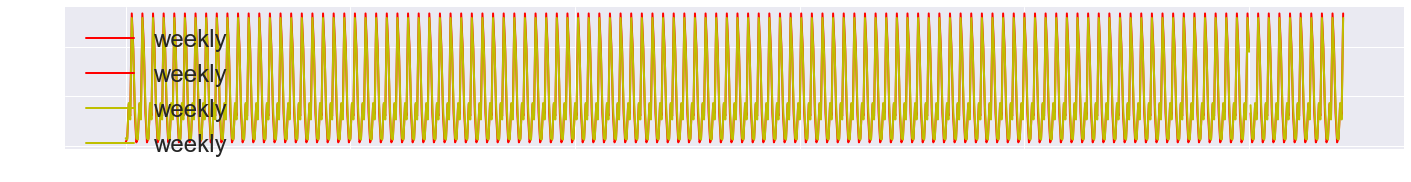

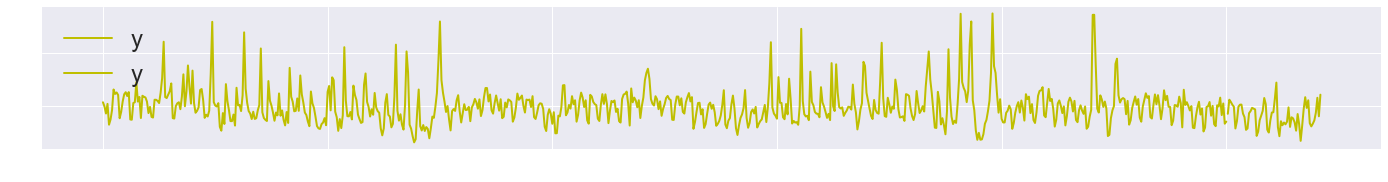

In [34]:
import itertools

def plot_component(results, results_train, component):
    colors = itertools.cycle(('r', 'y')) #, 'b', 'g'))
    for j, r in enumerate(results):
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        c = next(colors)
        plt.plot(ts["future"]["t"], df[component], color=c)
        plt.plot(ts["history"]["t"], df_train[component], color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
ts_selected = [1]
for i in ts_selected:
    ts = ts_data[i]
    colors = itertools.cycle(('r', 'y')) #, 'b', 'g'))
    # True
    plt.plot(ts["history"]["t"], ts["history"]["y_scaled"], lw=1, color='g')
    plt.plot(ts["future"]["t"], ts["future"]["y_scaled"], lw=1, color='g')
    for j, r in enumerate(results[:1]):
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        c = next(colors)
        plt.plot(ts["future"]["t"], df["y"], label="Model %d" % j, color=c)
        plt.plot(ts["history"]["t"], df_train["y"], color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
    plt.subplot(411)
    plot_component(results, results_train, "trend")
    plt.subplot(412)
    plot_component(results, results_train, "yearly")
    plt.subplot(413)
    plot_component(results, results_train, "weekly")
    plt.subplot(414)
    for j, r in enumerate(results[:1]):
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        c = next(colors)
        plt.plot(ts["future"]["t"], ts["future"]["y_scaled"].as_matrix() - df["y"] , color=c)
        plt.plot(ts["history"]["t"], ts["history"]["y_scaled"].as_matrix() - df_train["y"], color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.show()
print()

Model  0


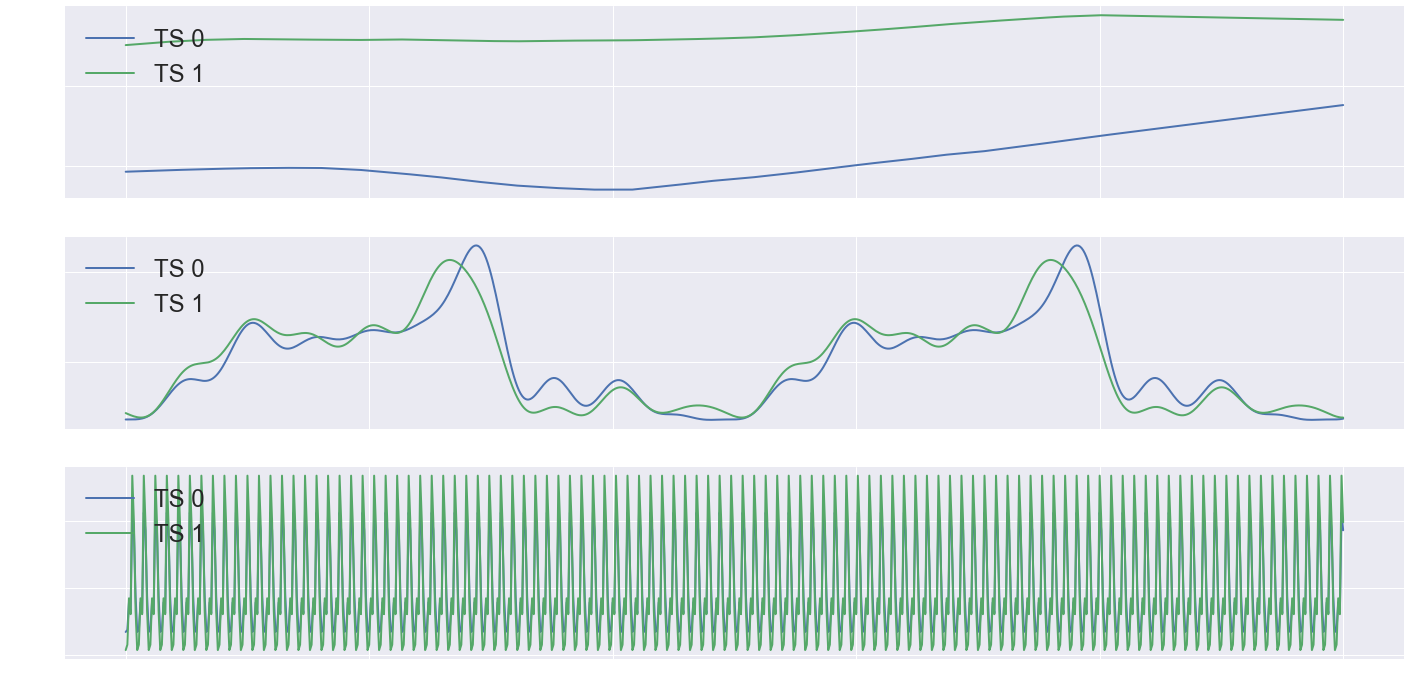

Model  1


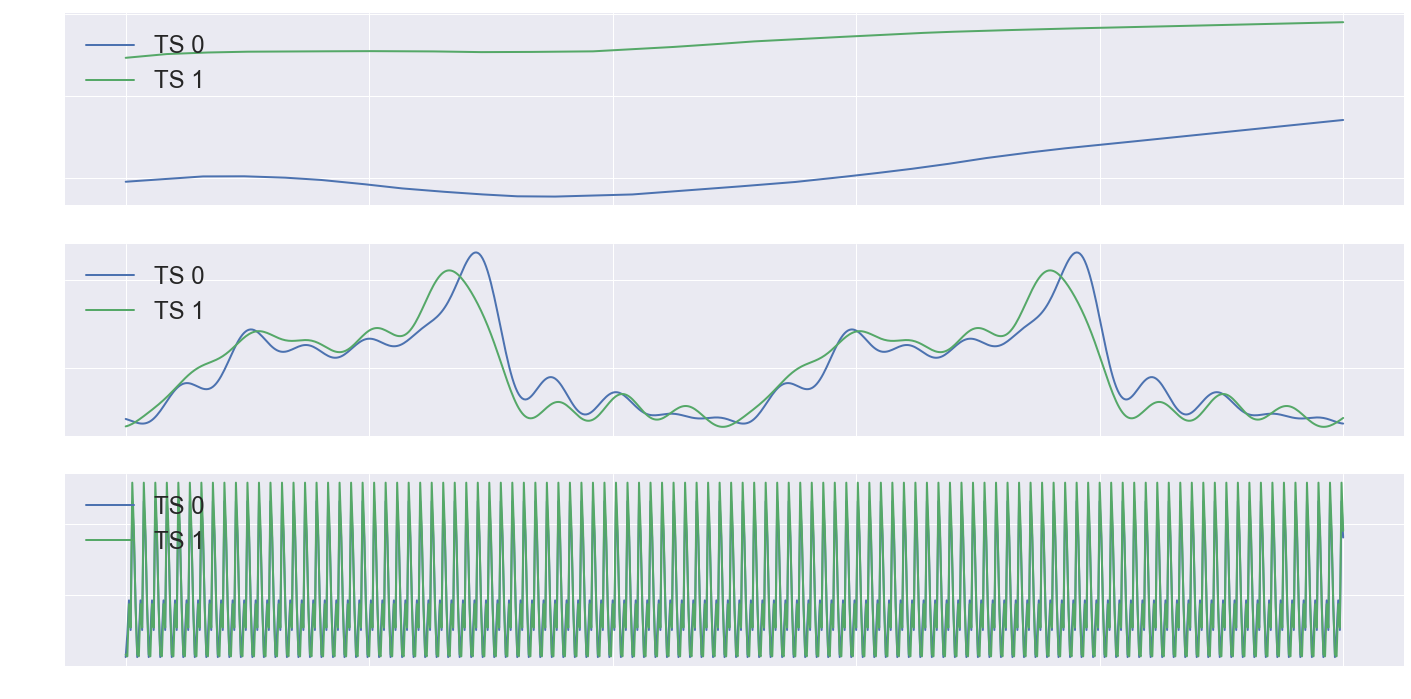

Model  0


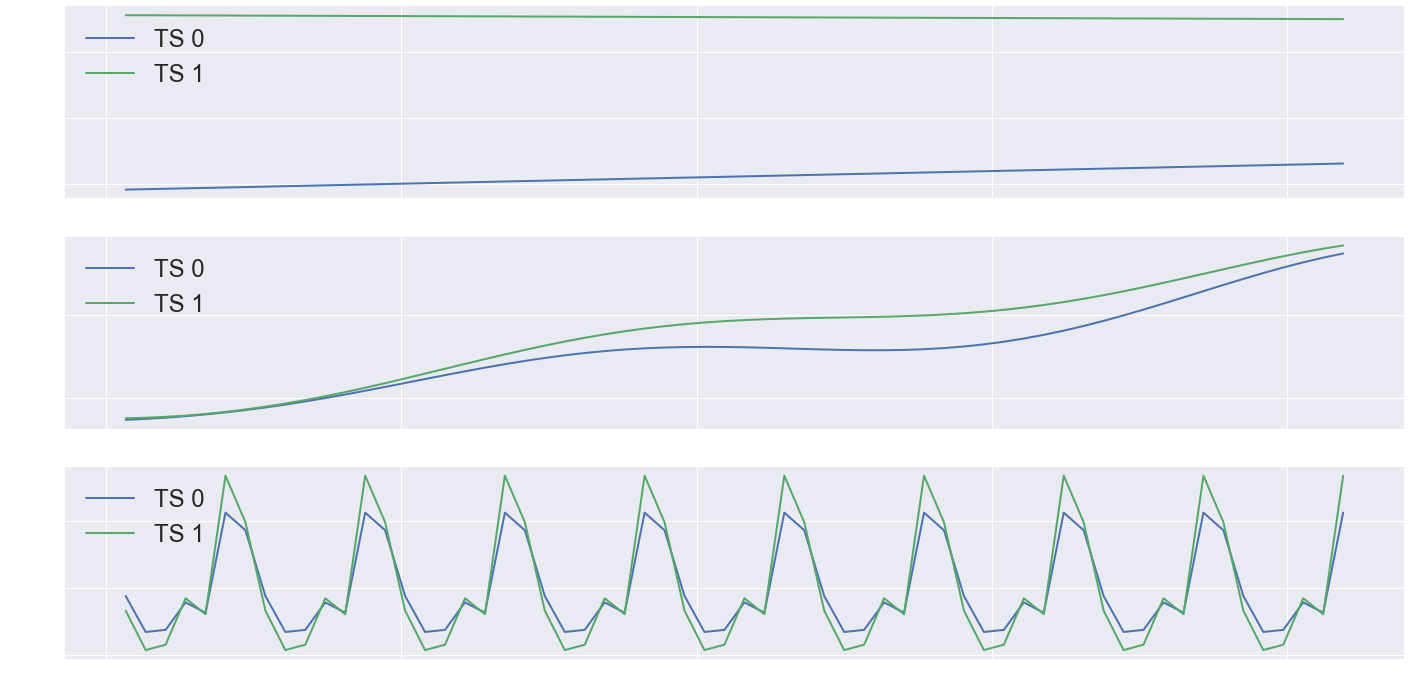

Model  1


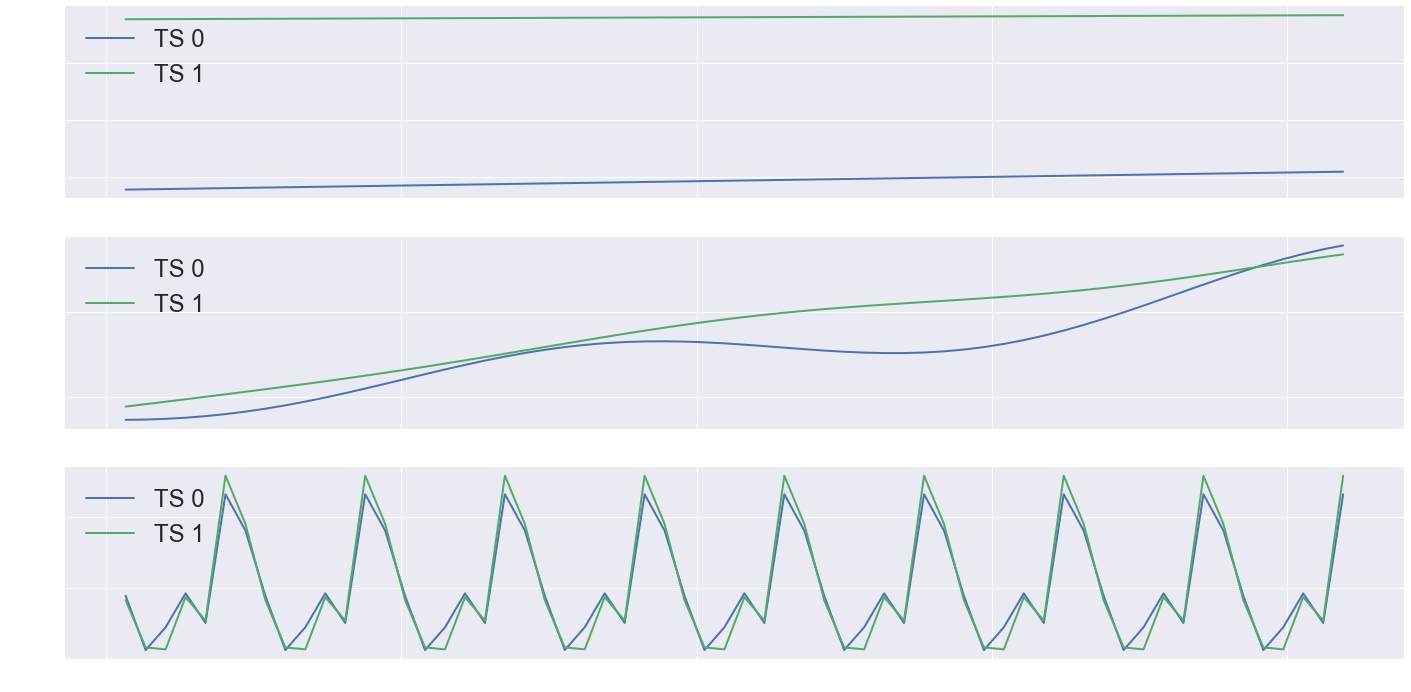

In [22]:
#ts_selected = [1, 3, 5]
ts_selected = [0, 1]
for j, r in enumerate(results):
    print("Model % d" % j)
    plt.subplot(311)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["history"]["t"], df_train["trend"], label="TS %d" % i) #, color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.subplot(312)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i]
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["history"]["t"], df_train["yearly"], label="TS %d" % i) #, color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.subplot(313)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["history"]["t"], df_train["weekly"], label="TS %d" % i) #, color=c)
        plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
#ts_selected = [1, 3, 5]
ts_selected = [0, 1]
for j, r in enumerate(results):
    print("Model % d" % j)
    plt.subplot(311)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["future"]["t"], df["trend"], label="TS %d" % i) #, color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.subplot(312)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i]
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["future"]["t"], df["yearly"], label="TS %d" % i) #, color=c)
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.subplot(313)
    for i in ts_selected:
        ts = ts_data[i]
        df = r["predictions"][i] 
        df_train = results_train[j]["predictions"][i]
        plt.plot(ts["future"]["t"], df["weekly"], label="TS %d" % i) #, color=c)
        plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
    

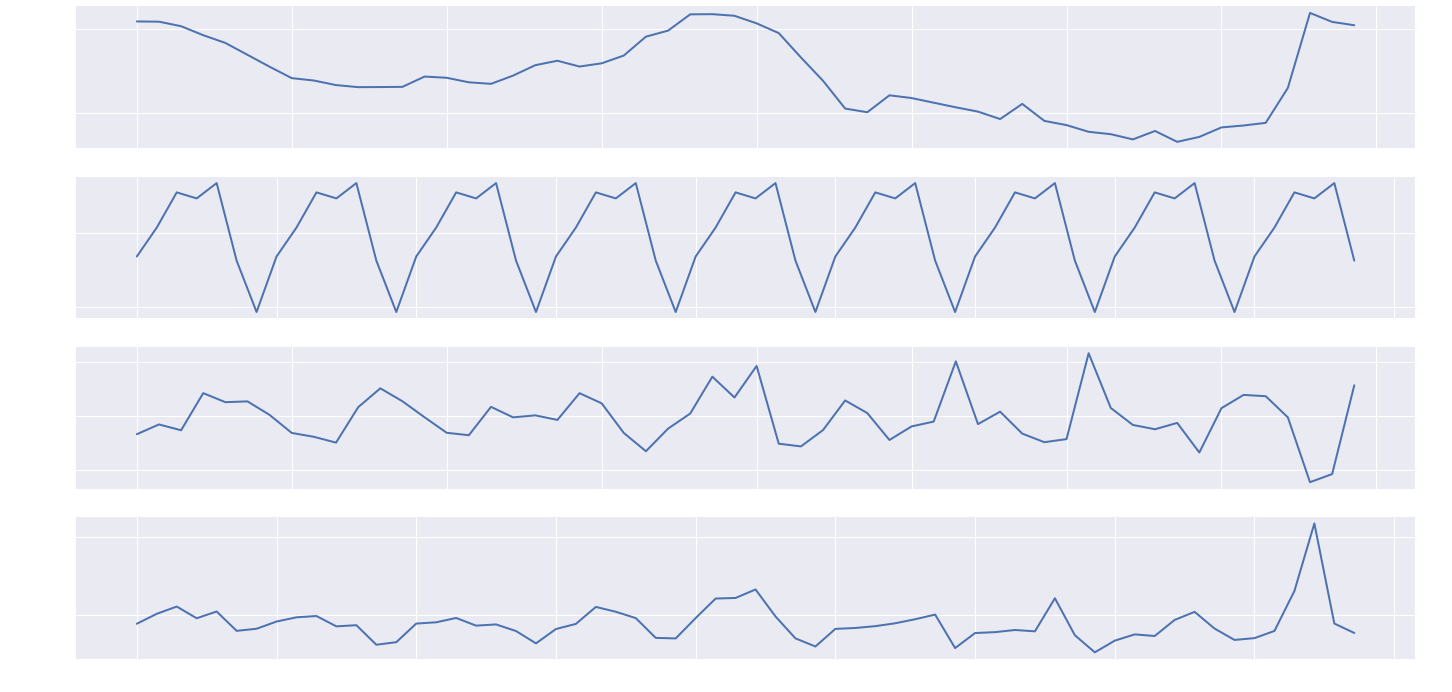

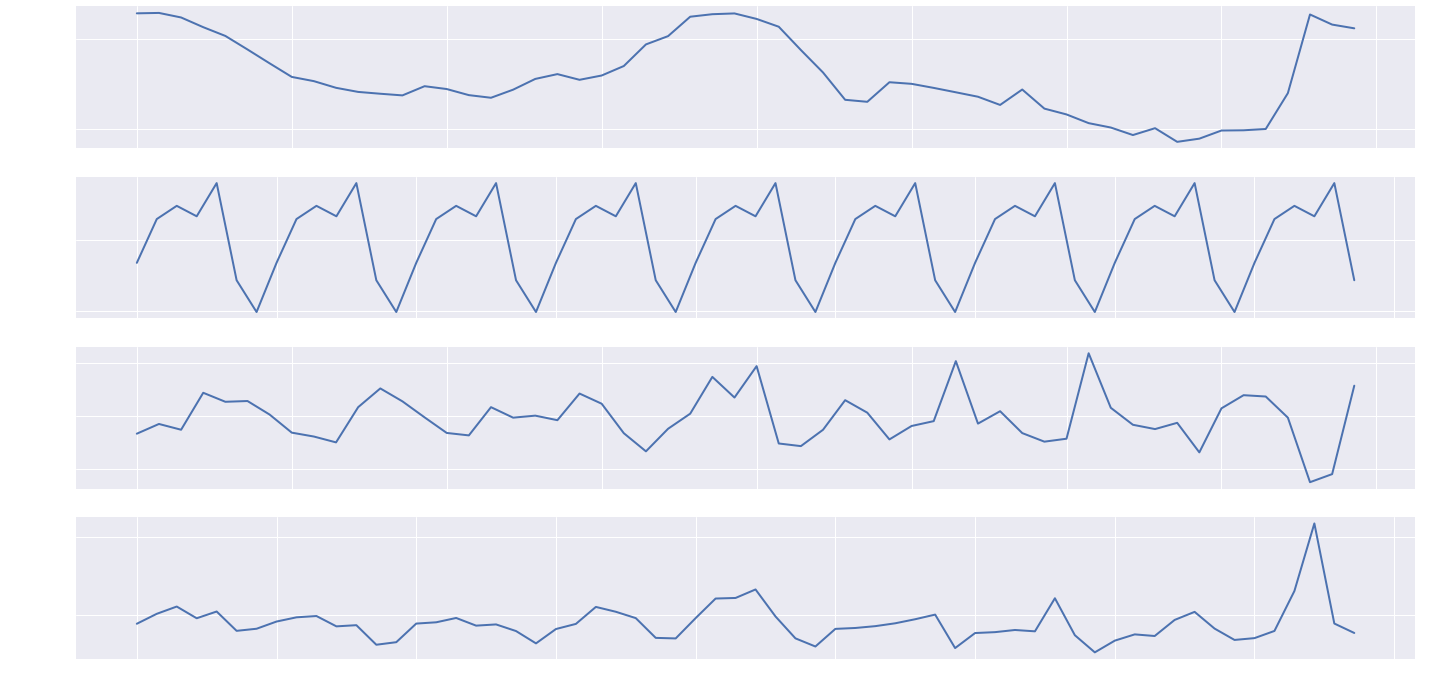

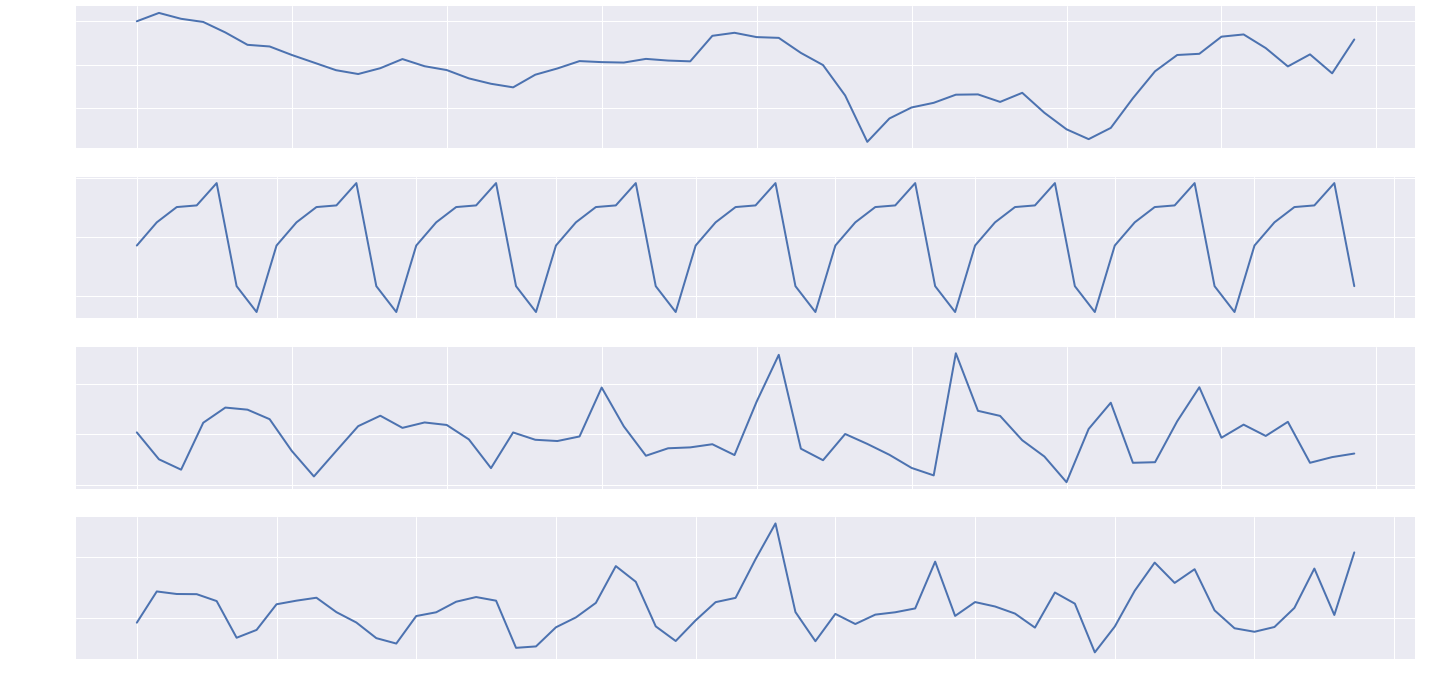

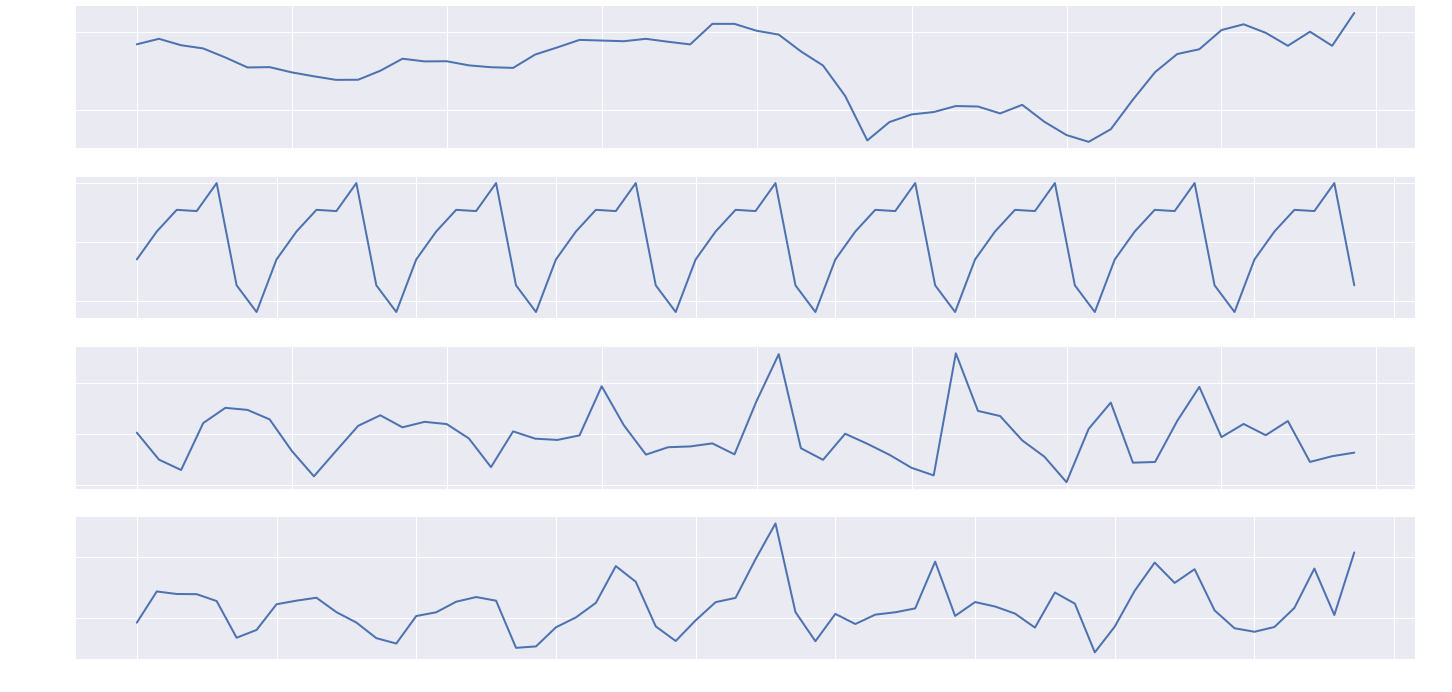

In [23]:
def plot_composition(df, y_true): 
    df.index = df["ds"]
    decomposition = seasonal_decompose(y_true - df["y"])
    plt.subplot(411) 
    plt.plot(decomposition.trend)
    plt.subplot(412)
    plt.plot(decomposition.seasonal)
    plt.subplot(413)
    plt.plot(decomposition.resid)
    plt.subplot(414)
    plt.plot(df["ds"], y_true - pred_df["y"])
    plt.show()
        
    
for i, ts in enumerate(ts_data[:2]):
    for j, r in enumerate(results):
        df = r["predictions"][i]
        plot_composition(df, ts["future"]["y_scaled"].as_matrix())

## Conclusion and Lessions Learned